# Notebook Data Science Thesis
#### Bente de Keizer 2023377

## Step 1: Import packages

In [ ]:
# standard packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#modelling packages
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from itertools import product
!pip install catboost
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# random resampling
!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


## Step 2: Import datasets and concatting

In [ ]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn_R2.csv')
df1 = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn_R2_Test.csv')

In [ ]:
dflist = [df,df1]
df = pd.concat(dflist, ignore_index=True)

## Step 3: Data description and change datatypes

### Variables and observations of the new dataframe

There are 7032 observations with 21 variables related to personal information, contract details, extra services and churn status.

* Personal information: customerID, gender, SeniorCitizen, Partner, Dependents

* Contract details: MultipleLines, Internetservice, MonthlyCharges, TotalCharges, PaymentMethod, Contract, Tenure, Contract, PhoneService, PaperlessBilling

* Extra services: TechSupport, StreamingTV, StreamingMovies, OnlineSecurity, OnlineBackup, DeviceProtection

* Churn

In [ ]:
df.shape

(7032, 21)

In [ ]:
df.dtypes

customerID           object
gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
Tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

### Change datatypes and values

In [ ]:
variable_names = df.columns.tolist()
variable_names = [i for i in variable_names if i not in ['customerID', 'Tenure', 'MonthlyCharges', 'TotalCharges']]

for i in variable_names:
    df[i] = df[i].astype("category")

df.dtypes

customerID            object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
Tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn               category
dtype: object

## Step 4: Data exploration

### Calculating churn rate

There are 1869 respondents who churned versus 5163 respondents who decided to stay loyal thus 26.6%

In [ ]:
df['Churn'].value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

In [ ]:
(1869/7032)*100

26.578498293515356

### Gender

In [ ]:
churn_by_gender = df.groupby(['gender', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_gender = df.groupby('gender')['Churn'].count().reset_index(name='Total_Count')
churn_by_gender = pd.merge(churn_by_gender, total_by_gender, on='gender')
churn_by_gender['Churn_Percentage'] = (churn_by_gender['Churn_Count'] / churn_by_gender['Total_Count']) * 100
print(churn_by_gender)

  gender Churn  Churn_Count  Total_Count  Churn_Percentage
0      0     0         2544         3483         73.040482
1      0     1          939         3483         26.959518
2      1     0         2619         3549         73.795435
3      1     1          930         3549         26.204565


### SeniorCitizen

In [ ]:
churn_by_senior = df.groupby(['SeniorCitizen', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_senior = df.groupby('SeniorCitizen')['Churn'].count().reset_index(name='Total_Count')
churn_by_senior = pd.merge(churn_by_senior, total_by_senior, on='SeniorCitizen')
churn_by_senior['Churn_Percentage'] = (churn_by_senior['Churn_Count'] / churn_by_senior['Total_Count']) * 100
print(churn_by_senior)

  SeniorCitizen Churn  Churn_Count  Total_Count  Churn_Percentage
0             0     0         4497         5890         76.349745
1             0     1         1393         5890         23.650255
2             1     0          666         1142         58.318739
3             1     1          476         1142         41.681261


### Partner

In [ ]:
churn_by_partner = df.groupby(['Partner', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_partner = df.groupby('Partner')['Churn'].count().reset_index(name='Total_Count')
churn_by_partner = pd.merge(churn_by_partner, total_by_partner, on='Partner')
churn_by_partner['Churn_Percentage'] = (churn_by_partner['Churn_Count'] / churn_by_partner['Total_Count']) * 100
print(churn_by_partner)

  Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0       0     0         2439         3639         67.023908
1       0     1         1200         3639         32.976092
2       1     0         2724         3393         80.282935
3       1     1          669         3393         19.717065


### Dependents

In [ ]:
churn_by_dependents = df.groupby(['Dependents', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_partner = df.groupby('Dependents')['Churn'].count().reset_index(name='Total_Count')
churn_by_dependents = pd.merge(churn_by_dependents, total_by_partner, on='Dependents')
churn_by_dependents['Churn_Percentage'] = (churn_by_dependents['Churn_Count'] / churn_by_dependents['Total_Count']) * 100
print(churn_by_dependents)

  Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0          0     0         3390         4933         68.720860
1          0     1         1543         4933         31.279140
2          1     0         1773         2099         84.468795
3          1     1          326         2099         15.531205


### Boxplot Tenure: loyal versus churned customers

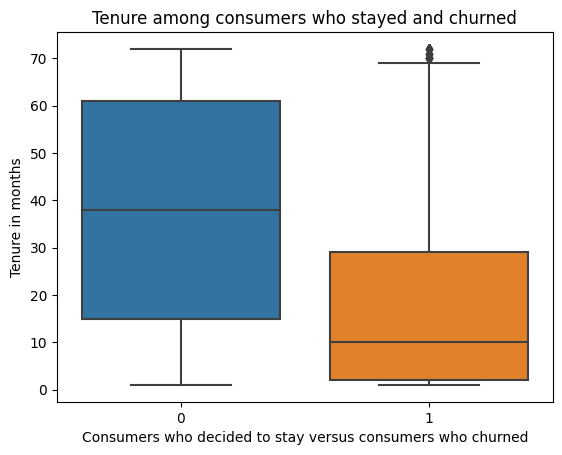

In [ ]:
sns.boxplot(x='Churn', y = 'Tenure', data = df)
plt.title('Tenure among consumers who stayed and churned')
plt.ylabel("Tenure in months")
plt.xlabel("Consumers who decided to stay versus consumers who churned")
plt.show()

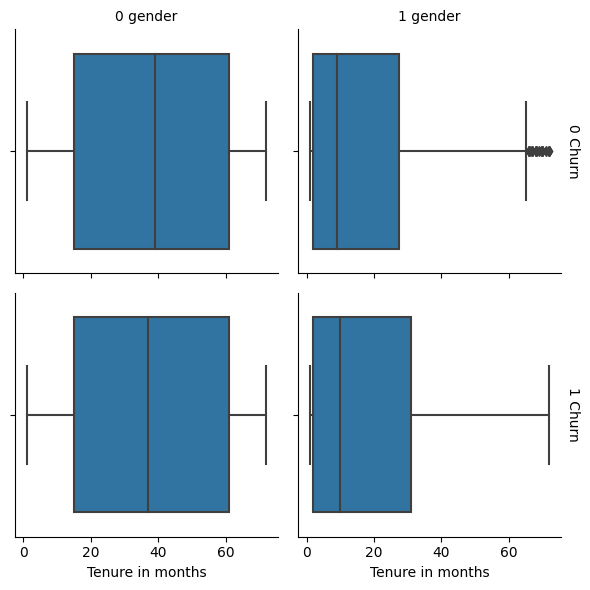

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="gender", margin_titles=True)
g.map(sns.boxplot, 'Tenure', order=churn_order)
g.set_axis_labels("Tenure in months")
g.set_titles(col_template="{col_name} gender", row_template="{row_name} Churn")
plt.show();

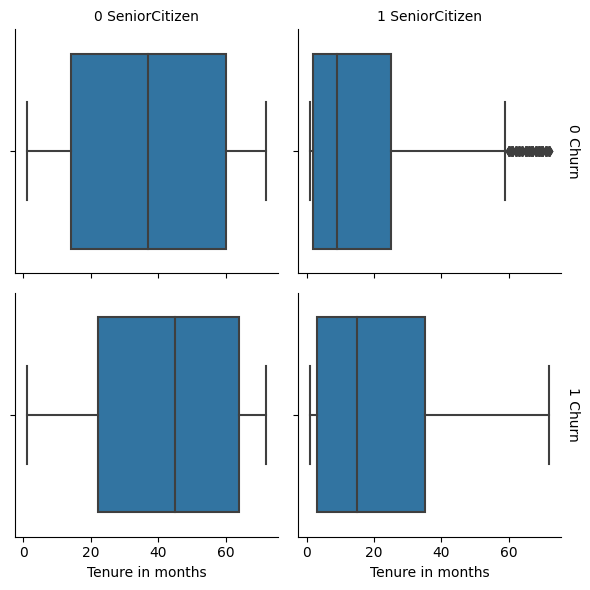

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="SeniorCitizen", margin_titles=True)
g.map(sns.boxplot, 'Tenure', order=churn_order)
g.set_axis_labels("Tenure in months")
g.set_titles(col_template="{col_name} SeniorCitizen", row_template="{row_name} Churn")
plt.show();

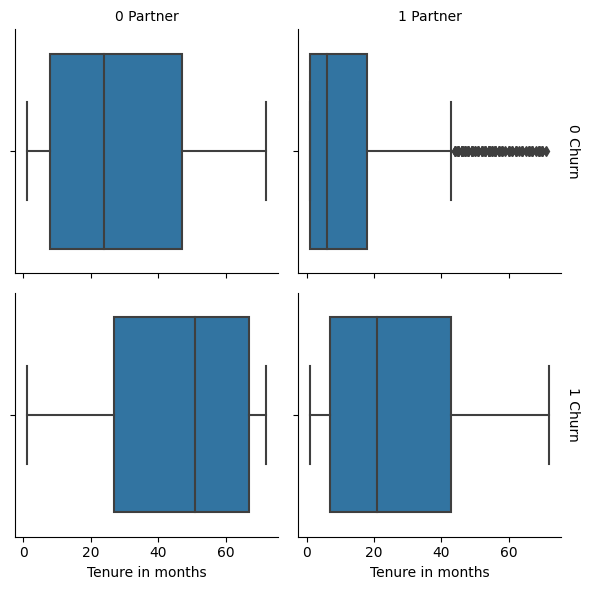

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="Partner", margin_titles=True)
g.map(sns.boxplot, 'Tenure', order=churn_order)
g.set_axis_labels("Tenure in months")
g.set_titles(col_template="{col_name} Partner", row_template="{row_name} Churn")
plt.show();

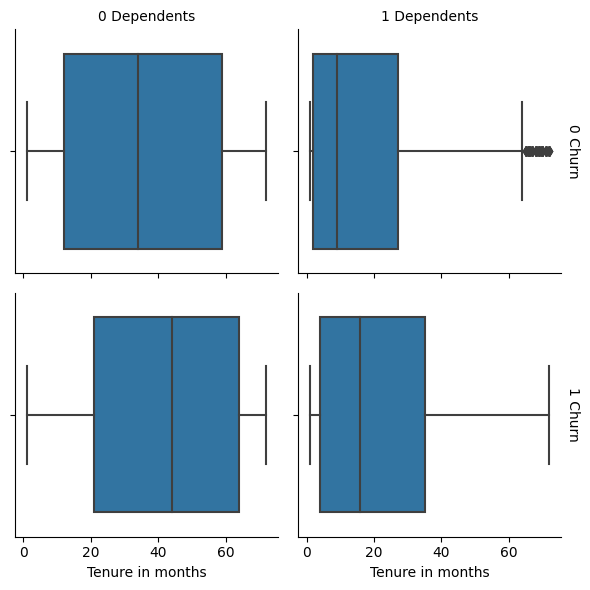

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="Dependents", margin_titles=True)
g.map(sns.boxplot, 'Tenure', order=churn_order)
g.set_axis_labels("Tenure in months")
g.set_titles(col_template="{col_name} Dependents", row_template="{row_name} Churn")
plt.show();

### Contract types

In [ ]:
churn_by_contract = df.groupby(['Contract', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_contract = df.groupby('Contract')['Churn'].count().reset_index(name='Total_Count')
churn_by_contract = pd.merge(churn_by_contract, total_by_contract, on='Contract')
churn_by_contract['Churn_Percentage'] = (churn_by_contract['Churn_Count'] / churn_by_contract['Total_Count']) * 100
print(churn_by_contract)

  Contract Churn  Churn_Count  Total_Count  Churn_Percentage
0        0     0         2220         3875         57.290323
1        0     1         1655         3875         42.709677
2        1     0         1306         1472         88.722826
3        1     1          166         1472         11.277174
4        2     0         1637         1685         97.151335
5        2     1           48         1685          2.848665


In [ ]:
churn_by_contract = df.groupby(['Contract', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_contract = df.groupby(['Contract', 'gender']).size().reset_index(name='Total_Count')
churn_by_contract = pd.merge(churn_by_contract, total_by_contract, on=['Contract', 'gender'])
churn_by_contract['Churn_Percentage'] = (churn_by_contract['Churn_Count'] / churn_by_contract['Total_Count']) * 100
print(churn_by_contract)

   Contract gender Churn  Churn_Count  Total_Count  Churn_Percentage
0         0      0     0         1083         1925         56.259740
1         0      0     1          842         1925         43.740260
2         0      1     0         1137         1950         58.307692
3         0      1     1          813         1950         41.692308
4         1      0     0          643          718         89.554318
5         1      0     1           75          718         10.445682
6         1      1     0          663          754         87.931034
7         1      1     1           91          754         12.068966
8         2      0     0          818          840         97.380952
9         2      0     1           22          840          2.619048
10        2      1     0          819          845         96.923077
11        2      1     1           26          845          3.076923


In [ ]:
churn_by_contract = df.groupby(['Contract', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_contract = df.groupby(['Contract', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_contract = pd.merge(churn_by_contract, total_by_contract, on=['Contract', 'SeniorCitizen'])
churn_by_contract['Churn_Percentage'] = (churn_by_contract['Churn_Count'] / churn_by_contract['Total_Count']) * 100
print(churn_by_contract)

   Contract SeniorCitizen Churn  Churn_Count  Total_Count  Churn_Percentage
0         0             0     0         1854         3068         60.430248
1         0             0     1         1214         3068         39.569752
2         0             1     0          366          807         45.353160
3         0             1     1          441          807         54.646840
4         1             0     0         1145         1282         89.313573
5         1             0     1          137         1282         10.686427
6         1             1     0          161          190         84.736842
7         1             1     1           29          190         15.263158
8         2             0     0         1498         1540         97.272727
9         2             0     1           42         1540          2.727273
10        2             1     0          139          145         95.862069
11        2             1     1            6          145          4.137931


In [ ]:
churn_by_contract = df.groupby(['Contract', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_contract = df.groupby(['Contract', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_contract = pd.merge(churn_by_contract, total_by_contract, on=['Contract', 'Dependents'])
churn_by_contract['Churn_Percentage'] = (churn_by_contract['Churn_Count'] / churn_by_contract['Total_Count']) * 100
print(churn_by_contract)

   Contract Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0         0          0     0         1690         3086         54.763448
1         0          0     1         1396         3086         45.236552
2         0          1     0          530          789         67.173638
3         0          1     1          259          789         32.826362
4         1          0     0          825          942         87.579618
5         1          0     1          117          942         12.420382
6         1          1     0          481          530         90.754717
7         1          1     1           49          530          9.245283
8         2          0     0          875          905         96.685083
9         2          0     1           30          905          3.314917
10        2          1     0          762          780         97.692308
11        2          1     1           18          780          2.307692


In [ ]:
churn_by_contract = df.groupby(['Contract', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_contract = df.groupby(['Contract', 'Partner']).size().reset_index(name='Total_Count')
churn_by_contract = pd.merge(churn_by_contract, total_by_contract, on=['Contract', 'Partner'])
churn_by_contract['Churn_Percentage'] = (churn_by_contract['Churn_Count'] / churn_by_contract['Total_Count']) * 100
print(churn_by_contract)

   Contract Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0         0       0     0         1380         2495         55.310621
1         0       0     1         1115         2495         44.689379
2         0       1     0          840         1380         60.869565
3         0       1     1          540         1380         39.130435
4         1       0     0          575          643         89.424572
5         1       0     1           68          643         10.575428
6         1       1     0          731          829         88.178528
7         1       1     1           98          829         11.821472
8         2       0     0          484          501         96.606786
9         2       0     1           17          501          3.393214
10        2       1     0         1153         1184         97.381757
11        2       1     1           31         1184          2.618243


### PaymentMethod

In [ ]:
churn_by_PaymentMethod = df.groupby(['PaymentMethod', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_PaymentMethod = df.groupby('PaymentMethod')['Churn'].count().reset_index(name='Total_Count')
churn_by_PaymentMethod = pd.merge(churn_by_PaymentMethod, total_by_PaymentMethod, on='PaymentMethod')
churn_by_PaymentMethod['Churn_Percentage'] = (churn_by_PaymentMethod['Churn_Count'] / churn_by_PaymentMethod['Total_Count']) * 100
print(churn_by_PaymentMethod)

  PaymentMethod Churn  Churn_Count  Total_Count  Churn_Percentage
0             0     0         1284         1542         83.268482
1             0     1          258         1542         16.731518
2             1     0         1289         1521         84.746877
3             1     1          232         1521         15.253123
4             2     0         1294         2365         54.714588
5             2     1         1071         2365         45.285412
6             3     0         1296         1604         80.798005
7             3     1          308         1604         19.201995


In [ ]:
churn_by_PaymentMethod = df.groupby(['PaymentMethod', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaymentMethod = df.groupby(['PaymentMethod', 'gender']).size().reset_index(name='Total_Count')
churn_by_PaymentMethod = pd.merge(churn_by_PaymentMethod, total_by_PaymentMethod, on=['PaymentMethod', 'gender'])
churn_by_PaymentMethod['Churn_Percentage'] = (churn_by_PaymentMethod['Churn_Count'] / churn_by_PaymentMethod['Total_Count']) * 100
print(churn_by_PaymentMethod)

   PaymentMethod gender Churn  Churn_Count  Total_Count  Churn_Percentage
0              0      0     0          651          787         82.719187
1              0      0     1          136          787         17.280813
2              0      1     0          633          755         83.841060
3              0      1     1          122          755         16.158940
4              1      0     0          620          751         82.556591
5              1      0     1          131          751         17.443409
6              1      1     0          669          770         86.883117
7              1      1     1          101          770         13.116883
8              2      0     0          648         1170         55.384615
9              2      0     1          522         1170         44.615385
10             2      1     0          646         1195         54.058577
11             2      1     1          549         1195         45.941423
12             3      0     0         

In [ ]:
churn_by_PaymentMethod = df.groupby(['PaymentMethod', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaymentMethod = df.groupby(['PaymentMethod', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_PaymentMethod = pd.merge(churn_by_PaymentMethod, total_by_PaymentMethod, on=['PaymentMethod', 'SeniorCitizen'])
churn_by_PaymentMethod['Churn_Percentage'] = (churn_by_PaymentMethod['Churn_Count'] / churn_by_PaymentMethod['Total_Count']) * 100
print(churn_by_PaymentMethod)

   PaymentMethod SeniorCitizen Churn  Churn_Count  Total_Count  \
0              0             0     0         1104         1309   
1              0             0     1          205         1309   
2              0             1     0          180          233   
3              0             1     1           53          233   
4              1             0     0         1130         1300   
5              1             0     1          170         1300   
6              1             1     0          159          221   
7              1             1     1           62          221   
8              2             0     0         1017         1771   
9              2             0     1          754         1771   
10             2             1     0          277          594   
11             2             1     1          317          594   
12             3             0     0         1246         1510   
13             3             0     1          264         1510   
14        

In [ ]:
churn_by_PaymentMethod = df.groupby(['PaymentMethod', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaymentMethod = df.groupby(['PaymentMethod', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_PaymentMethod = pd.merge(churn_by_PaymentMethod, total_by_PaymentMethod, on=['PaymentMethod', 'Dependents'])
churn_by_PaymentMethod['Churn_Percentage'] = (churn_by_PaymentMethod['Churn_Count'] / churn_by_PaymentMethod['Total_Count']) * 100
print(churn_by_PaymentMethod)

   PaymentMethod Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0              0          0     0          815         1012         80.533597
1              0          0     1          197         1012         19.466403
2              0          1     0          469          530         88.490566
3              0          1     1           61          530         11.509434
4              1          0     0          799          986         81.034483
5              1          0     1          187          986         18.965517
6              1          1     0          490          535         91.588785
7              1          1     1           45          535          8.411215
8              2          0     0          969         1886         51.378579
9              2          0     1          917         1886         48.621421
10             2          1     0          325          479         67.849687
11             2          1     1          154          479     

In [ ]:
churn_by_PaymentMethod = df.groupby(['PaymentMethod', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaymentMethod = df.groupby(['PaymentMethod', 'Partner']).size().reset_index(name='Total_Count')
churn_by_PaymentMethod = pd.merge(churn_by_PaymentMethod, total_by_PaymentMethod, on=['PaymentMethod', 'Partner'])
churn_by_PaymentMethod['Churn_Percentage'] = (churn_by_PaymentMethod['Churn_Count'] / churn_by_PaymentMethod['Total_Count']) * 100
print(churn_by_PaymentMethod)

   PaymentMethod Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0              0       0     0          502          636         78.930818
1              0       0     1          134          636         21.069182
2              0       1     0          782          906         86.313466
3              0       1     1          124          906         13.686534
4              1       0     0          527          668         78.892216
5              1       0     1          141          668         21.107784
6              1       1     0          762          853         89.331770
7              1       1     1           91          853         10.668230
8              2       0     0          670         1362         49.192364
9              2       0     1          692         1362         50.807636
10             2       1     0          624         1003         62.213360
11             2       1     1          379         1003         37.786640
12             3       0 

### MonthlyCharges

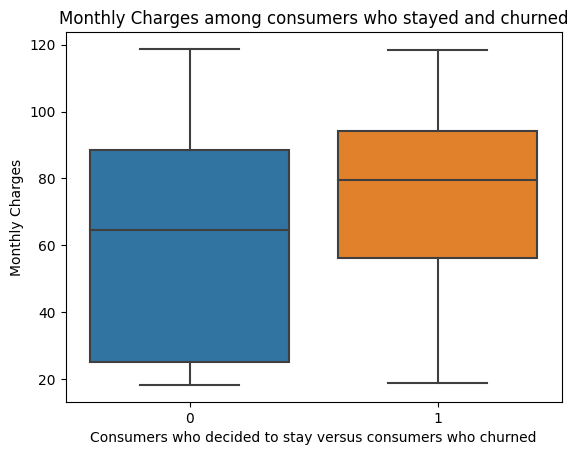

In [ ]:
sns.boxplot(x='Churn', y = 'MonthlyCharges', data = df)
plt.title('Monthly Charges among consumers who stayed and churned')
plt.ylabel("Monthly Charges")
plt.xlabel("Consumers who decided to stay versus consumers who churned")
plt.show()

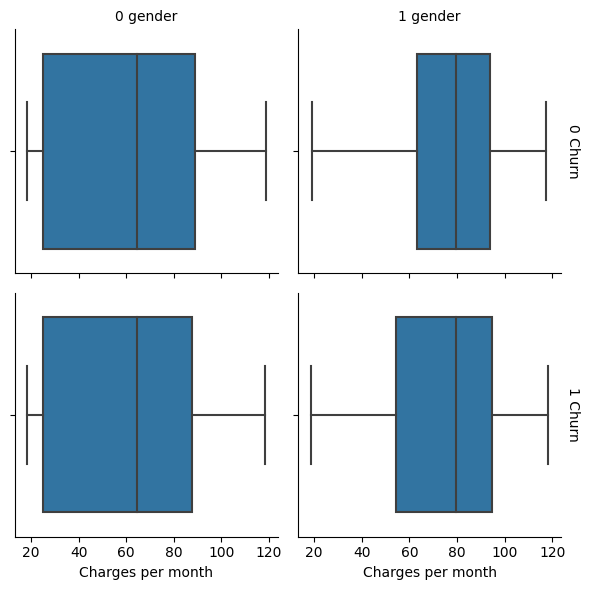

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="gender", margin_titles=True)
g.map(sns.boxplot, 'MonthlyCharges', order=churn_order)
g.set_axis_labels("Charges per month")
g.set_titles(col_template="{col_name} gender", row_template="{row_name} Churn")
plt.show();

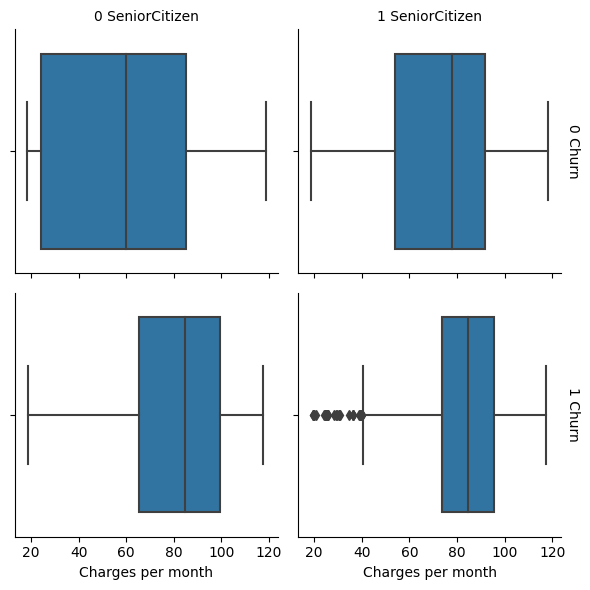

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="SeniorCitizen", margin_titles=True)
g.map(sns.boxplot, 'MonthlyCharges', order=churn_order)
g.set_axis_labels("Charges per month")
g.set_titles(col_template="{col_name} SeniorCitizen", row_template="{row_name} Churn")
plt.show();

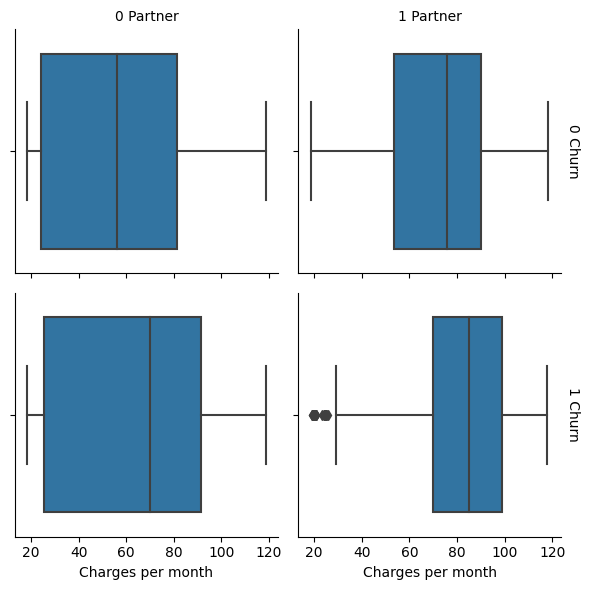

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="Partner", margin_titles=True)
g.map(sns.boxplot, 'MonthlyCharges', order=churn_order)
g.set_axis_labels("Charges per month")
g.set_titles(col_template="{col_name} Partner", row_template="{row_name} Churn")
plt.show();

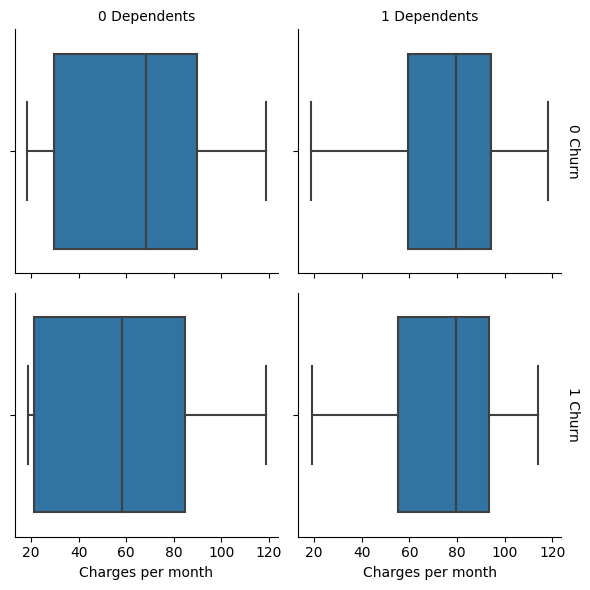

In [ ]:
churn_order = [0, 1]
g = sns.FacetGrid(df, col="Churn", row="Dependents", margin_titles=True)
g.map(sns.boxplot, 'MonthlyCharges', order=churn_order)
g.set_axis_labels("Charges per month")
g.set_titles(col_template="{col_name} Dependents", row_template="{row_name} Churn")
plt.show();

### InternetService

In [ ]:
churn_by_internetservice = df.groupby(['InternetService', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_internetservice = df.groupby('InternetService')['Churn'].count().reset_index(name='Total_Count')
churn_by_internetservice = pd.merge(churn_by_internetservice, total_by_internetservice, on='InternetService')
churn_by_internetservice['Churn_Percentage'] = (churn_by_internetservice['Churn_Count'] / churn_by_internetservice['Total_Count']) * 100
print(churn_by_internetservice)

  InternetService Churn  Churn_Count  Total_Count  Churn_Percentage
0               0     0         1407         1520         92.565789
1               0     1          113         1520          7.434211
2               1     0         1957         2416         81.001656
3               1     1          459         2416         18.998344
4               2     0         1799         3096         58.107235
5               2     1         1297         3096         41.892765


In [ ]:
churn_by_internetservice = df.groupby(['InternetService', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_internetservice = df.groupby(['InternetService', 'gender']).size().reset_index(name='Total_Count')
churn_by_internetservice = pd.merge(churn_by_internetservice, total_by_internetservice, on=['InternetService', 'gender'])
churn_by_internetservice['Churn_Percentage'] = (churn_by_internetservice['Churn_Count'] / churn_by_internetservice['Total_Count']) * 100
print(churn_by_internetservice)

   InternetService gender Churn  Churn_Count  Total_Count  Churn_Percentage
0                0      0     0          690          746         92.493298
1                0      0     1           56          746          7.506702
2                0      1     0          717          774         92.635659
3                0      1     1           57          774          7.364341
4                1      0     0          965         1184         81.503378
5                1      0     1          219         1184         18.496622
6                1      1     0          992         1232         80.519481
7                1      1     1          240         1232         19.480519
8                2      0     0          889         1553         57.244044
9                2      0     1          664         1553         42.755956
10               2      1     0          910         1543         58.976021
11               2      1     1          633         1543         41.023979


In [ ]:
churn_by_internetservice = df.groupby(['InternetService', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_internetservice = df.groupby(['InternetService', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_internetservice = pd.merge(churn_by_internetservice, total_by_internetservice, on=['InternetService', 'SeniorCitizen'])
churn_by_internetservice['Churn_Percentage'] = (churn_by_internetservice['Churn_Count'] / churn_by_internetservice['Total_Count']) * 100
print(churn_by_internetservice)

   InternetService SeniorCitizen Churn  Churn_Count  Total_Count  \
0                0             0     0         1360         1468   
1                0             0     1          108         1468   
2                0             1     0           47           52   
3                0             1     1            5           52   
4                1             0     0         1776         2157   
5                1             0     1          381         2157   
6                1             1     0          181          259   
7                1             1     1           78          259   
8                2             0     0         1361         2265   
9                2             0     1          904         2265   
10               2             1     0          438          831   
11               2             1     1          393          831   

    Churn_Percentage  
0          92.643052  
1           7.356948  
2          90.384615  
3           9.615385  


In [ ]:
churn_by_internetservice = df.groupby(['InternetService', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_internetservice = df.groupby(['InternetService', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_internetservice = pd.merge(churn_by_internetservice, total_by_internetservice, on=['InternetService', 'Dependents'])
churn_by_internetservice['Churn_Percentage'] = (churn_by_internetservice['Churn_Count'] / churn_by_internetservice['Total_Count']) * 100
print(churn_by_internetservice)

   InternetService Dependents Churn  Churn_Count  Total_Count  \
0                0          0     0          798          883   
1                0          0     1           85          883   
2                0          1     0          609          637   
3                0          1     1           28          637   
4                1          0     0         1253         1616   
5                1          0     1          363         1616   
6                1          1     0          704          800   
7                1          1     1           96          800   
8                2          0     0         1339         2434   
9                2          0     1         1095         2434   
10               2          1     0          460          662   
11               2          1     1          202          662   

    Churn_Percentage  
0          90.373726  
1           9.626274  
2          95.604396  
3           4.395604  
4          77.537129  
5          22.46

In [ ]:
churn_by_internetservice = df.groupby(['InternetService', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_internetservice = df.groupby(['InternetService', 'Partner']).size().reset_index(name='Total_Count')
churn_by_internetservice = pd.merge(churn_by_internetservice, total_by_internetservice, on=['InternetService', 'Partner'])
churn_by_internetservice['Churn_Percentage'] = (churn_by_internetservice['Churn_Count'] / churn_by_internetservice['Total_Count']) * 100
print(churn_by_internetservice)

   InternetService Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0                0       0     0          703          787         89.326557
1                0       0     1           84          787         10.673443
2                0       1     0          704          733         96.043656
3                0       1     1           29          733          3.956344
4                1       0     0          931         1252         74.361022
5                1       0     1          321         1252         25.638978
6                1       1     0         1026         1164         88.144330
7                1       1     1          138         1164         11.855670
8                2       0     0          805         1600         50.312500
9                2       0     1          795         1600         49.687500
10               2       1     0          994         1496         66.443850
11               2       1     1          502         1496         33.556150

### PhoneService

In [ ]:
churn_by_PhoneService = df.groupby(['PhoneService', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_PhoneService = df.groupby('PhoneService')['Churn'].count().reset_index(name='Total_Count')
churn_by_PhoneService = pd.merge(churn_by_PhoneService, total_by_PhoneService, on='PhoneService')
churn_by_PhoneService['Churn_Percentage'] = (churn_by_PhoneService['Churn_Count'] / churn_by_PhoneService['Total_Count']) * 100
print(churn_by_PhoneService)

  PhoneService Churn  Churn_Count  Total_Count  Churn_Percentage
0            0     0          510          680         75.000000
1            0     1          170          680         25.000000
2            1     0         4653         6352         73.252519
3            1     1         1699         6352         26.747481


In [ ]:
churn_by_PhoneService = df.groupby(['PhoneService', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PhoneService = df.groupby(['PhoneService', 'gender']).size().reset_index(name='Total_Count')
churn_by_PhoneService = pd.merge(churn_by_PhoneService, total_by_PhoneService, on=['PhoneService', 'gender'])
churn_by_PhoneService['Churn_Percentage'] = (churn_by_PhoneService['Churn_Count'] / churn_by_PhoneService['Total_Count']) * 100
print(churn_by_PhoneService)

  PhoneService gender Churn  Churn_Count  Total_Count  Churn_Percentage
0            0      0     0          249          329         75.683891
1            0      0     1           80          329         24.316109
2            0      1     0          261          351         74.358974
3            0      1     1           90          351         25.641026
4            1      0     0         2295         3154         72.764743
5            1      0     1          859         3154         27.235257
6            1      1     0         2358         3198         73.733583
7            1      1     1          840         3198         26.266417


In [ ]:
churn_by_PhoneService = df.groupby(['PhoneService', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PhoneService = df.groupby(['PhoneService', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_PhoneService = pd.merge(churn_by_PhoneService, total_by_PhoneService, on=['PhoneService', 'SeniorCitizen'])
churn_by_PhoneService['Churn_Percentage'] = (churn_by_PhoneService['Churn_Count'] / churn_by_PhoneService['Total_Count']) * 100
print(churn_by_PhoneService)

  PhoneService SeniorCitizen Churn  Churn_Count  Total_Count  Churn_Percentage
0            0             0     0          450          576         78.125000
1            0             0     1          126          576         21.875000
2            0             1     0           60          104         57.692308
3            0             1     1           44          104         42.307692
4            1             0     0         4047         5314         76.157320
5            1             0     1         1267         5314         23.842680
6            1             1     0          606         1038         58.381503
7            1             1     1          432         1038         41.618497


In [ ]:
churn_by_PhoneService = df.groupby(['PhoneService', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PhoneService = df.groupby(['PhoneService', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_PhoneService = pd.merge(churn_by_PhoneService, total_by_PhoneService, on=['PhoneService', 'Dependents'])
churn_by_PhoneService['Churn_Percentage'] = (churn_by_PhoneService['Churn_Count'] / churn_by_PhoneService['Total_Count']) * 100
print(churn_by_PhoneService)

  PhoneService Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0            0          0     0          329          476         69.117647
1            0          0     1          147          476         30.882353
2            0          1     0          181          204         88.725490
3            0          1     1           23          204         11.274510
4            1          0     0         3061         4457         68.678483
5            1          0     1         1396         4457         31.321517
6            1          1     0         1592         1895         84.010554
7            1          1     1          303         1895         15.989446


In [ ]:
churn_by_PhoneService = df.groupby(['PhoneService', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PhoneService = df.groupby(['PhoneService', 'Partner']).size().reset_index(name='Total_Count')
churn_by_PhoneService = pd.merge(churn_by_PhoneService, total_by_PhoneService, on=['PhoneService', 'Partner'])
churn_by_PhoneService['Churn_Percentage'] = (churn_by_PhoneService['Churn_Count'] / churn_by_PhoneService['Total_Count']) * 100
print(churn_by_PhoneService)

  PhoneService Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0            0       0     0          262          371         70.619946
1            0       0     1          109          371         29.380054
2            0       1     0          248          309         80.258900
3            0       1     1           61          309         19.741100
4            1       0     0         2177         3268         66.615667
5            1       0     1         1091         3268         33.384333
6            1       1     0         2476         3084         80.285344
7            1       1     1          608         3084         19.714656


### Multiplelines

In [ ]:
churn_by_multiplelines = df.groupby(['MultipleLines', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_multiplelines = df.groupby('MultipleLines')['Churn'].count().reset_index(name='Total_Count')
churn_by_multiplelines = pd.merge(churn_by_multiplelines, total_by_multiplelines, on='MultipleLines')
churn_by_multiplelines['Churn_Percentage'] = (churn_by_multiplelines['Churn_Count'] / churn_by_multiplelines['Total_Count']) * 100
print(churn_by_multiplelines)

  MultipleLines Churn  Churn_Count  Total_Count  Churn_Percentage
0             0     0         3046         4065         74.932349
1             0     1         1019         4065         25.067651
2             1     0         2117         2967         71.351534
3             1     1          850         2967         28.648466


In [ ]:
churn_by_multiplelines = df.groupby(['MultipleLines', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_multiplelines = df.groupby(['MultipleLines', 'gender']).size().reset_index(name='Total_Count')
churn_by_multiplelines = pd.merge(churn_by_multiplelines, total_by_multiplelines, on=['MultipleLines', 'gender'])
churn_by_multiplelines['Churn_Percentage'] = (churn_by_multiplelines['Churn_Count'] / churn_by_multiplelines['Total_Count']) * 100
print(churn_by_multiplelines)

  MultipleLines gender Churn  Churn_Count  Total_Count  Churn_Percentage
0             0      0     0         1475         1998         73.823824
1             0      0     1          523         1998         26.176176
2             0      1     0         1571         2067         76.003870
3             0      1     1          496         2067         23.996130
4             1      0     0         1069         1485         71.986532
5             1      0     1          416         1485         28.013468
6             1      1     0         1048         1482         70.715250
7             1      1     1          434         1482         29.284750


In [ ]:
churn_by_multiplelines = df.groupby(['MultipleLines', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_multiplelines = df.groupby(['MultipleLines', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_multiplelines = pd.merge(churn_by_multiplelines, total_by_multiplelines, on=['MultipleLines', 'SeniorCitizen'])
churn_by_multiplelines['Churn_Percentage'] = (churn_by_multiplelines['Churn_Count'] / churn_by_multiplelines['Total_Count']) * 100
print(churn_by_multiplelines)

  MultipleLines SeniorCitizen Churn  Churn_Count  Total_Count  \
0             0             0     0         2765         3588   
1             0             0     1          823         3588   
2             0             1     0          281          477   
3             0             1     1          196          477   
4             1             0     0         1732         2302   
5             1             0     1          570         2302   
6             1             1     0          385          665   
7             1             1     1          280          665   

   Churn_Percentage  
0         77.062430  
1         22.937570  
2         58.909853  
3         41.090147  
4         75.238923  
5         24.761077  
6         57.894737  
7         42.105263  


In [ ]:
churn_by_multiplelines = df.groupby(['MultipleLines', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_multiplelines = df.groupby(['MultipleLines', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_multiplelines = pd.merge(churn_by_multiplelines, total_by_multiplelines, on=['MultipleLines', 'Dependents'])
churn_by_multiplelines['Churn_Percentage'] = (churn_by_multiplelines['Churn_Count'] / churn_by_multiplelines['Total_Count']) * 100
print(churn_by_multiplelines)

  MultipleLines Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0             0          0     0         1986         2813         70.600782
1             0          0     1          827         2813         29.399218
2             0          1     0         1060         1252         84.664537
3             0          1     1          192         1252         15.335463
4             1          0     0         1404         2120         66.226415
5             1          0     1          716         2120         33.773585
6             1          1     0          713          847         84.179457
7             1          1     1          134          847         15.820543


In [ ]:
churn_by_multiplelines = df.groupby(['MultipleLines', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_multiplelines = df.groupby(['MultipleLines', 'Partner']).size().reset_index(name='Total_Count')
churn_by_multiplelines = pd.merge(churn_by_multiplelines, total_by_multiplelines, on=['MultipleLines', 'Partner'])
churn_by_multiplelines['Churn_Percentage'] = (churn_by_multiplelines['Churn_Count'] / churn_by_multiplelines['Total_Count']) * 100
print(churn_by_multiplelines)

  MultipleLines Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0             0       0     0         1633         2351         69.459804
1             0       0     1          718         2351         30.540196
2             0       1     0         1413         1714         82.438740
3             0       1     1          301         1714         17.561260
4             1       0     0          806         1288         62.577640
5             1       0     1          482         1288         37.422360
6             1       1     0         1311         1679         78.082192
7             1       1     1          368         1679         21.917808


### PaperlessBilling

In [ ]:
churn_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_PaperlessBilling = df.groupby('PaperlessBilling')['Churn'].count().reset_index(name='Total_Count')
churn_by_PaperlessBilling = pd.merge(churn_by_PaperlessBilling, total_by_PaperlessBilling, on='PaperlessBilling')
churn_by_PaperlessBilling['Churn_Percentage'] = (churn_by_PaperlessBilling['Churn_Count'] / churn_by_PaperlessBilling['Total_Count']) * 100
print(churn_by_PaperlessBilling)

  PaperlessBilling Churn  Churn_Count  Total_Count  Churn_Percentage
0                0     0         2395         2864         83.624302
1                0     1          469         2864         16.375698
2                1     0         2768         4168         66.410749
3                1     1         1400         4168         33.589251


In [ ]:
churn_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'gender']).size().reset_index(name='Total_Count')
churn_by_PaperlessBilling = pd.merge(churn_by_PaperlessBilling, total_by_PaperlessBilling, on=['PaperlessBilling', 'gender'])
churn_by_PaperlessBilling['Churn_Percentage'] = (churn_by_PaperlessBilling['Churn_Count'] / churn_by_PaperlessBilling['Total_Count']) * 100
print(churn_by_PaperlessBilling)

  PaperlessBilling gender Churn  Churn_Count  Total_Count  Churn_Percentage
0                0      0     0         1158         1398         82.832618
1                0      0     1          240         1398         17.167382
2                0      1     0         1237         1466         84.379263
3                0      1     1          229         1466         15.620737
4                1      0     0         1386         2085         66.474820
5                1      0     1          699         2085         33.525180
6                1      1     0         1382         2083         66.346615
7                1      1     1          701         2083         33.653385


In [ ]:
churn_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_PaperlessBilling = pd.merge(churn_by_PaperlessBilling, total_by_PaperlessBilling, on=['PaperlessBilling', 'SeniorCitizen'])
churn_by_PaperlessBilling['Churn_Percentage'] = (churn_by_PaperlessBilling['Churn_Count'] / churn_by_PaperlessBilling['Total_Count']) * 100
print(churn_by_PaperlessBilling)

  PaperlessBilling SeniorCitizen Churn  Churn_Count  Total_Count  \
0                0             0     0         2207         2598   
1                0             0     1          391         2598   
2                0             1     0          188          266   
3                0             1     1           78          266   
4                1             0     0         2290         3292   
5                1             0     1         1002         3292   
6                1             1     0          478          876   
7                1             1     1          398          876   

   Churn_Percentage  
0         84.949962  
1         15.050038  
2         70.676692  
3         29.323308  
4         69.562576  
5         30.437424  
6         54.566210  
7         45.433790  


In [ ]:
churn_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_PaperlessBilling = pd.merge(churn_by_PaperlessBilling, total_by_PaperlessBilling, on=['PaperlessBilling', 'Dependents'])
churn_by_PaperlessBilling['Churn_Percentage'] = (churn_by_PaperlessBilling['Churn_Count'] / churn_by_PaperlessBilling['Total_Count']) * 100
print(churn_by_PaperlessBilling)

  PaperlessBilling Dependents Churn  Churn_Count  Total_Count  \
0                0          0     0         1474         1835   
1                0          0     1          361         1835   
2                0          1     0          921         1029   
3                0          1     1          108         1029   
4                1          0     0         1916         3098   
5                1          0     1         1182         3098   
6                1          1     0          852         1070   
7                1          1     1          218         1070   

   Churn_Percentage  
0         80.326975  
1         19.673025  
2         89.504373  
3         10.495627  
4         61.846352  
5         38.153648  
6         79.626168  
7         20.373832  


In [ ]:
churn_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_PaperlessBilling = df.groupby(['PaperlessBilling', 'Partner']).size().reset_index(name='Total_Count')
churn_by_PaperlessBilling = pd.merge(churn_by_PaperlessBilling, total_by_PaperlessBilling, on=['PaperlessBilling', 'Partner'])
churn_by_PaperlessBilling['Churn_Percentage'] = (churn_by_PaperlessBilling['Churn_Count'] / churn_by_PaperlessBilling['Total_Count']) * 100
print(churn_by_PaperlessBilling)

  PaperlessBilling Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0                0       0     0         1151         1458         78.943759
1                0       0     1          307         1458         21.056241
2                0       1     0         1244         1406         88.477952
3                0       1     1          162         1406         11.522048
4                1       0     0         1288         2181         59.055479
5                1       0     1          893         2181         40.944521
6                1       1     0         1480         1987         74.484147
7                1       1     1          507         1987         25.515853


### StreamingMovies

In [ ]:
churn_by_movies = df.groupby(['StreamingMovies', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_movies = df.groupby('StreamingMovies')['Churn'].count().reset_index(name='Total_Count')
churn_by_movies = pd.merge(churn_by_movies, total_by_movies, on='StreamingMovies')
churn_by_movies['Churn_Percentage'] = (churn_by_movies['Churn_Count'] / churn_by_movies['Total_Count']) * 100
print(churn_by_movies)

  StreamingMovies Churn  Churn_Count  Total_Count  Churn_Percentage
0               0     0         1843         2781         66.271125
1               0     1          938         2781         33.728875
2               1     0         1913         2731         70.047602
3               1     1          818         2731         29.952398
4               2     0         1407         1520         92.565789
5               2     1          113         1520          7.434211


In [ ]:
churn_by_movies = df.groupby(['StreamingMovies', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_movies = df.groupby(['StreamingMovies', 'gender']).size().reset_index(name='Total_Count')
churn_by_movies = pd.merge(churn_by_movies, total_by_movies, on=['StreamingMovies', 'gender'])
churn_by_movies['Churn_Percentage'] = (churn_by_movies['Churn_Count'] / churn_by_movies['Total_Count']) * 100
print(churn_by_movies)

   StreamingMovies gender Churn  Churn_Count  Total_Count  Churn_Percentage
0                0      0     0          891         1367         65.179225
1                0      0     1          476         1367         34.820775
2                0      1     0          952         1414         67.326733
3                0      1     1          462         1414         32.673267
4                1      0     0          963         1370         70.291971
5                1      0     1          407         1370         29.708029
6                1      1     0          950         1361         69.801616
7                1      1     1          411         1361         30.198384
8                2      0     0          690          746         92.493298
9                2      0     1           56          746          7.506702
10               2      1     0          717          774         92.635659
11               2      1     1           57          774          7.364341


In [ ]:
churn_by_movies = df.groupby(['StreamingMovies', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_movies = df.groupby(['StreamingMovies', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_movies = pd.merge(churn_by_movies, total_by_movies, on=['StreamingMovies', 'SeniorCitizen'])
churn_by_movies['Churn_Percentage'] = (churn_by_movies['Churn_Count'] / churn_by_movies['Total_Count']) * 100
print(churn_by_movies)

   StreamingMovies SeniorCitizen Churn  Churn_Count  Total_Count  \
0                0             0     0         1575         2286   
1                0             0     1          711         2286   
2                0             1     0          268          495   
3                0             1     1          227          495   
4                1             0     0         1562         2136   
5                1             0     1          574         2136   
6                1             1     0          351          595   
7                1             1     1          244          595   
8                2             0     0         1360         1468   
9                2             0     1          108         1468   
10               2             1     0           47           52   
11               2             1     1            5           52   

    Churn_Percentage  
0          68.897638  
1          31.102362  
2          54.141414  
3          45.858586  


In [ ]:
churn_by_movies = df.groupby(['StreamingMovies', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_movies = df.groupby(['StreamingMovies', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_movies = pd.merge(churn_by_movies, total_by_movies, on=['StreamingMovies', 'Dependents'])
churn_by_movies['Churn_Percentage'] = (churn_by_movies['Churn_Count'] / churn_by_movies['Total_Count']) * 100
print(churn_by_movies)

   StreamingMovies Dependents Churn  Churn_Count  Total_Count  \
0                0          0     0         1295         2074   
1                0          0     1          779         2074   
2                0          1     0          548          707   
3                0          1     1          159          707   
4                1          0     0         1297         1976   
5                1          0     1          679         1976   
6                1          1     0          616          755   
7                1          1     1          139          755   
8                2          0     0          798          883   
9                2          0     1           85          883   
10               2          1     0          609          637   
11               2          1     1           28          637   

    Churn_Percentage  
0          62.439730  
1          37.560270  
2          77.510608  
3          22.489392  
4          65.637652  
5          34.36

In [ ]:
churn_by_movies = df.groupby(['StreamingMovies', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_movies = df.groupby(['StreamingMovies', 'Partner']).size().reset_index(name='Total_Count')
churn_by_movies = pd.merge(churn_by_movies, total_by_movies, on=['StreamingMovies', 'Partner'])
churn_by_movies['Churn_Percentage'] = (churn_by_movies['Churn_Count'] / churn_by_movies['Total_Count']) * 100
print(churn_by_movies)

   StreamingMovies Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0                0       0     0          989         1641         60.268129
1                0       0     1          652         1641         39.731871
2                0       1     0          854         1140         74.912281
3                0       1     1          286         1140         25.087719
4                1       0     0          747         1211         61.684558
5                1       0     1          464         1211         38.315442
6                1       1     0         1166         1520         76.710526
7                1       1     1          354         1520         23.289474
8                2       0     0          703          787         89.326557
9                2       0     1           84          787         10.673443
10               2       1     0          704          733         96.043656
11               2       1     1           29          733          3.956344

### StreamingTV

In [ ]:
churn_by_TV = df.groupby(['StreamingTV', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_TV = df.groupby('StreamingTV')['Churn'].count().reset_index(name='Total_Count')
churn_by_TV = pd.merge(churn_by_TV, total_by_TV, on='StreamingTV')
churn_by_TV['Churn_Percentage'] = (churn_by_TV['Churn_Count'] / churn_by_TV['Total_Count']) * 100
print(churn_by_TV)

  StreamingTV Churn  Churn_Count  Total_Count  Churn_Percentage
0           0     0         1867         2809         66.464934
1           0     1          942         2809         33.535066
2           1     0         1889         2703         69.885313
3           1     1          814         2703         30.114687
4           2     0         1407         1520         92.565789
5           2     1          113         1520          7.434211


In [ ]:
churn_by_TV = df.groupby(['StreamingTV', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_TV = df.groupby(['StreamingTV', 'gender']).size().reset_index(name='Total_Count')
churn_by_TV = pd.merge(churn_by_TV, total_by_TV, on=['StreamingTV', 'gender'])
churn_by_TV['Churn_Percentage'] = (churn_by_TV['Churn_Count'] / churn_by_TV['Total_Count']) * 100
print(churn_by_TV)

   StreamingTV gender Churn  Churn_Count  Total_Count  Churn_Percentage
0            0      0     0          905         1386         65.295815
1            0      0     1          481         1386         34.704185
2            0      1     0          962         1423         67.603654
3            0      1     1          461         1423         32.396346
4            1      0     0          949         1351         70.244264
5            1      0     1          402         1351         29.755736
6            1      1     0          940         1352         69.526627
7            1      1     1          412         1352         30.473373
8            2      0     0          690          746         92.493298
9            2      0     1           56          746          7.506702
10           2      1     0          717          774         92.635659
11           2      1     1           57          774          7.364341


In [ ]:
churn_by_TV = df.groupby(['StreamingTV', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_TV = df.groupby(['StreamingTV', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_TV = pd.merge(churn_by_TV, total_by_TV, on=['StreamingTV', 'SeniorCitizen'])
churn_by_TV['Churn_Percentage'] = (churn_by_TV['Churn_Count'] / churn_by_TV['Total_Count']) * 100
print(churn_by_TV)

   StreamingTV SeniorCitizen Churn  Churn_Count  Total_Count  Churn_Percentage
0            0             0     0         1591         2291         69.445657
1            0             0     1          700         2291         30.554343
2            0             1     0          276          518         53.281853
3            0             1     1          242          518         46.718147
4            1             0     0         1546         2131         72.548099
5            1             0     1          585         2131         27.451901
6            1             1     0          343          572         59.965035
7            1             1     1          229          572         40.034965
8            2             0     0         1360         1468         92.643052
9            2             0     1          108         1468          7.356948
10           2             1     0           47           52         90.384615
11           2             1     1            5     

In [ ]:
churn_by_TV = df.groupby(['StreamingTV', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_TV = df.groupby(['StreamingTV', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_TV = pd.merge(churn_by_TV, total_by_TV, on=['StreamingTV', 'Dependents'])
churn_by_TV['Churn_Percentage'] = (churn_by_TV['Churn_Count'] / churn_by_TV['Total_Count']) * 100
print(churn_by_TV)

   StreamingTV Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0            0          0     0         1340         2128         62.969925
1            0          0     1          788         2128         37.030075
2            0          1     0          527          681         77.386197
3            0          1     1          154          681         22.613803
4            1          0     0         1252         1922         65.140479
5            1          0     1          670         1922         34.859521
6            1          1     0          637          781         81.562100
7            1          1     1          144          781         18.437900
8            2          0     0          798          883         90.373726
9            2          0     1           85          883          9.626274
10           2          1     0          609          637         95.604396
11           2          1     1           28          637          4.395604


In [ ]:
churn_by_TV = df.groupby(['StreamingTV', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_TV = df.groupby(['StreamingTV', 'Partner']).size().reset_index(name='Total_Count')
churn_by_TV = pd.merge(churn_by_TV, total_by_TV, on=['StreamingTV', 'Partner'])
churn_by_TV['Churn_Percentage'] = (churn_by_TV['Churn_Count'] / churn_by_TV['Total_Count']) * 100
print(churn_by_TV)

   StreamingTV Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0            0       0     0         1013         1666         60.804322
1            0       0     1          653         1666         39.195678
2            0       1     0          854         1143         74.715661
3            0       1     1          289         1143         25.284339
4            1       0     0          723         1186         60.961214
5            1       0     1          463         1186         39.038786
6            1       1     0         1166         1517         76.862228
7            1       1     1          351         1517         23.137772
8            2       0     0          703          787         89.326557
9            2       0     1           84          787         10.673443
10           2       1     0          704          733         96.043656
11           2       1     1           29          733          3.956344


### OnlineSecurity

In [ ]:
churn_by_onlinesecurity = df.groupby(['OnlineSecurity', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_onlinesecurity = df.groupby('OnlineSecurity')['Churn'].count().reset_index(name='Total_Count')
churn_by_onlinesecurity = pd.merge(churn_by_onlinesecurity, total_by_onlinesecurity, on='OnlineSecurity')
churn_by_onlinesecurity['Churn_Percentage'] = (churn_by_onlinesecurity['Churn_Count'] / churn_by_onlinesecurity['Total_Count']) * 100
print(churn_by_onlinesecurity)

  OnlineSecurity Churn  Churn_Count  Total_Count  Churn_Percentage
0              0     0         2036         3497         58.221333
1              0     1         1461         3497         41.778667
2              1     0         1720         2015         85.359801
3              1     1          295         2015         14.640199
4              2     0         1407         1520         92.565789
5              2     1          113         1520          7.434211


In [ ]:
churn_by_onlinesecurity = df.groupby(['OnlineSecurity', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinesecurity = df.groupby(['OnlineSecurity', 'gender']).size().reset_index(name='Total_Count')
churn_by_onlinesecurity = pd.merge(churn_by_onlinesecurity, total_by_onlinesecurity, on=['OnlineSecurity', 'gender'])
churn_by_onlinesecurity['Churn_Percentage'] = (churn_by_onlinesecurity['Churn_Count'] / churn_by_onlinesecurity['Total_Count']) * 100
print(churn_by_onlinesecurity)

   OnlineSecurity gender Churn  Churn_Count  Total_Count  Churn_Percentage
0               0      0     0          992         1713         57.910099
1               0      0     1          721         1713         42.089901
2               0      1     0         1044         1784         58.520179
3               0      1     1          740         1784         41.479821
4               1      0     0          862         1024         84.179688
5               1      0     1          162         1024         15.820312
6               1      1     0          858          991         86.579213
7               1      1     1          133          991         13.420787
8               2      0     0          690          746         92.493298
9               2      0     1           56          746          7.506702
10              2      1     0          717          774         92.635659
11              2      1     1           57          774          7.364341


In [ ]:
churn_by_onlinesecurity = df.groupby(['OnlineSecurity', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinesecurity = df.groupby(['OnlineSecurity', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_onlinesecurity = pd.merge(churn_by_onlinesecurity, total_by_onlinesecurity, on=['OnlineSecurity', 'SeniorCitizen'])
churn_by_onlinesecurity['Churn_Percentage'] = (churn_by_onlinesecurity['Churn_Count'] / churn_by_onlinesecurity['Total_Count']) * 100
print(churn_by_onlinesecurity)

   OnlineSecurity SeniorCitizen Churn  Churn_Count  Total_Count  \
0               0             0     0         1635         2689   
1               0             0     1         1054         2689   
2               0             1     0          401          808   
3               0             1     1          407          808   
4               1             0     0         1502         1733   
5               1             0     1          231         1733   
6               1             1     0          218          282   
7               1             1     1           64          282   
8               2             0     0         1360         1468   
9               2             0     1          108         1468   
10              2             1     0           47           52   
11              2             1     1            5           52   

    Churn_Percentage  
0          60.803273  
1          39.196727  
2          49.628713  
3          50.371287  
4          86

In [ ]:
churn_by_onlinesecurity = df.groupby(['OnlineSecurity', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinesecurity = df.groupby(['OnlineSecurity', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_onlinesecurity = pd.merge(churn_by_onlinesecurity, total_by_onlinesecurity, on=['OnlineSecurity', 'Dependents'])
churn_by_onlinesecurity['Churn_Percentage'] = (churn_by_onlinesecurity['Churn_Count'] / churn_by_onlinesecurity['Total_Count']) * 100
print(churn_by_onlinesecurity)

   OnlineSecurity Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0               0          0     0         1522         2754         55.265069
1               0          0     1         1232         2754         44.734931
2               0          1     0          514          743         69.179004
3               0          1     1          229          743         30.820996
4               1          0     0         1070         1296         82.561728
5               1          0     1          226         1296         17.438272
6               1          1     0          650          719         90.403338
7               1          1     1           69          719          9.596662
8               2          0     0          798          883         90.373726
9               2          0     1           85          883          9.626274
10              2          1     0          609          637         95.604396
11              2          1     1           28     

In [ ]:
churn_by_onlinesecurity = df.groupby(['OnlineSecurity', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinesecurity = df.groupby(['OnlineSecurity', 'Partner']).size().reset_index(name='Total_Count')
churn_by_onlinesecurity = pd.merge(churn_by_onlinesecurity, total_by_onlinesecurity, on=['OnlineSecurity', 'Partner'])
churn_by_onlinesecurity['Churn_Percentage'] = (churn_by_onlinesecurity['Churn_Count'] / churn_by_onlinesecurity['Total_Count']) * 100
print(churn_by_onlinesecurity)

   OnlineSecurity Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0               0       0     0         1077         2037         52.871870
1               0       0     1          960         2037         47.128130
2               0       1     0          959         1460         65.684932
3               0       1     1          501         1460         34.315068
4               1       0     0          659          815         80.858896
5               1       0     1          156          815         19.141104
6               1       1     0         1061         1200         88.416667
7               1       1     1          139         1200         11.583333
8               2       0     0          703          787         89.326557
9               2       0     1           84          787         10.673443
10              2       1     0          704          733         96.043656
11              2       1     1           29          733          3.956344


### OnlineBackup

In [ ]:
churn_by_onlinebackup = df.groupby(['OnlineBackup', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_onlinebackup = df.groupby('OnlineBackup')['Churn'].count().reset_index(name='Total_Count')
churn_by_onlinebackup = pd.merge(churn_by_onlinebackup, total_by_onlinebackup, on='OnlineBackup')
churn_by_onlinebackup['Churn_Percentage'] = (churn_by_onlinebackup['Churn_Count'] / churn_by_onlinebackup['Total_Count']) * 100
print(churn_by_onlinebackup)

  OnlineBackup Churn  Churn_Count  Total_Count  Churn_Percentage
0            0     0         1854         3087         60.058309
1            0     1         1233         3087         39.941691
2            1     0         1902         2425         78.432990
3            1     1          523         2425         21.567010
4            2     0         1407         1520         92.565789
5            2     1          113         1520          7.434211


In [ ]:
churn_by_onlinebackup = df.groupby(['OnlineBackup', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinebackup = df.groupby(['OnlineBackup', 'gender']).size().reset_index(name='Total_Count')
churn_by_onlinebackup = pd.merge(churn_by_onlinebackup, total_by_onlinebackup, on=['OnlineBackup', 'gender'])
churn_by_onlinebackup['Churn_Percentage'] = (churn_by_onlinebackup['Churn_Count'] / churn_by_onlinebackup['Total_Count']) * 100
print(churn_by_onlinebackup)

   OnlineBackup gender Churn  Churn_Count  Total_Count  Churn_Percentage
0             0      0     0          896         1514         59.180978
1             0      0     1          618         1514         40.819022
2             0      1     0          958         1573         60.902734
3             0      1     1          615         1573         39.097266
4             1      0     0          958         1223         78.331971
5             1      0     1          265         1223         21.668029
6             1      1     0          944         1202         78.535774
7             1      1     1          258         1202         21.464226
8             2      0     0          690          746         92.493298
9             2      0     1           56          746          7.506702
10            2      1     0          717          774         92.635659
11            2      1     1           57          774          7.364341


In [ ]:
churn_by_onlinebackup = df.groupby(['OnlineBackup', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinebackup = df.groupby(['OnlineBackup', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_onlinebackup = pd.merge(churn_by_onlinebackup, total_by_onlinebackup, on=['OnlineBackup', 'SeniorCitizen'])
churn_by_onlinebackup['Churn_Percentage'] = (churn_by_onlinebackup['Churn_Count'] / churn_by_onlinebackup['Total_Count']) * 100
print(churn_by_onlinebackup)

   OnlineBackup SeniorCitizen Churn  Churn_Count  Total_Count  \
0             0             0     0         1564         2473   
1             0             0     1          909         2473   
2             0             1     0          290          614   
3             0             1     1          324          614   
4             1             0     0         1573         1949   
5             1             0     1          376         1949   
6             1             1     0          329          476   
7             1             1     1          147          476   
8             2             0     0         1360         1468   
9             2             0     1          108         1468   
10            2             1     0           47           52   
11            2             1     1            5           52   

    Churn_Percentage  
0          63.243025  
1          36.756975  
2          47.231270  
3          52.768730  
4          80.708055  
5          19.29

In [ ]:
churn_by_onlinebackup = df.groupby(['OnlineBackup', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinebackup = df.groupby(['OnlineBackup', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_onlinebackup = pd.merge(churn_by_onlinebackup, total_by_onlinebackup, on=['OnlineBackup', 'Dependents'])
churn_by_onlinebackup['Churn_Percentage'] = (churn_by_onlinebackup['Churn_Count'] / churn_by_onlinebackup['Total_Count']) * 100
print(churn_by_onlinebackup)

   OnlineBackup Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0             0          0     0         1349         2385         56.561845
1             0          0     1         1036         2385         43.438155
2             0          1     0          505          702         71.937322
3             0          1     1          197          702         28.062678
4             1          0     0         1243         1665         74.654655
5             1          0     1          422         1665         25.345345
6             1          1     0          659          760         86.710526
7             1          1     1          101          760         13.289474
8             2          0     0          798          883         90.373726
9             2          0     1           85          883          9.626274
10            2          1     0          609          637         95.604396
11            2          1     1           28          637          4.395604

In [ ]:
churn_by_onlinebackup = df.groupby(['OnlineBackup', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_onlinebackup = df.groupby(['OnlineBackup', 'Partner']).size().reset_index(name='Total_Count')
churn_by_onlinebackup = pd.merge(churn_by_onlinebackup, total_by_onlinebackup, on=['OnlineBackup', 'Partner'])
churn_by_onlinebackup['Churn_Percentage'] = (churn_by_onlinebackup['Churn_Count'] / churn_by_onlinebackup['Total_Count']) * 100
print(churn_by_onlinebackup)

   OnlineBackup Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0             0       0     0         1004         1834         54.743730
1             0       0     1          830         1834         45.256270
2             0       1     0          850         1253         67.837191
3             0       1     1          403         1253         32.162809
4             1       0     0          732         1018         71.905697
5             1       0     1          286         1018         28.094303
6             1       1     0         1170         1407         83.155650
7             1       1     1          237         1407         16.844350
8             2       0     0          703          787         89.326557
9             2       0     1           84          787         10.673443
10            2       1     0          704          733         96.043656
11            2       1     1           29          733          3.956344


### DeviceProtection

In [ ]:
churn_by_deviceprotection = df.groupby(['DeviceProtection', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_deviceprotection = df.groupby('DeviceProtection')['Churn'].count().reset_index(name='Total_Count')
churn_by_deviceprotection = pd.merge(churn_by_deviceprotection, total_by_deviceprotection, on='DeviceProtection')
churn_by_deviceprotection['Churn_Percentage'] = (churn_by_deviceprotection['Churn_Count'] / churn_by_deviceprotection['Total_Count']) * 100
print(churn_by_deviceprotection)

  DeviceProtection Churn  Churn_Count  Total_Count  Churn_Percentage
0                0     0         1883         3094         60.859729
1                0     1         1211         3094         39.140271
2                1     0         1873         2418         77.460711
3                1     1          545         2418         22.539289
4                2     0         1407         1520         92.565789
5                2     1          113         1520          7.434211


In [ ]:
churn_by_deviceprotection = df.groupby(['DeviceProtection', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_deviceprotection = df.groupby(['DeviceProtection', 'gender']).size().reset_index(name='Total_Count')
churn_by_deviceprotection = pd.merge(churn_by_deviceprotection, total_by_deviceprotection, on=['DeviceProtection', 'gender'])
churn_by_deviceprotection['Churn_Percentage'] = (churn_by_deviceprotection['Churn_Count'] / churn_by_deviceprotection['Total_Count']) * 100
print(churn_by_deviceprotection)

   DeviceProtection gender Churn  Churn_Count  Total_Count  Churn_Percentage
0                 0      0     0          922         1538         59.947984
1                 0      0     1          616         1538         40.052016
2                 0      1     0          961         1556         61.760925
3                 0      1     1          595         1556         38.239075
4                 1      0     0          932         1199         77.731443
5                 1      0     1          267         1199         22.268557
6                 1      1     0          941         1219         77.194422
7                 1      1     1          278         1219         22.805578
8                 2      0     0          690          746         92.493298
9                 2      0     1           56          746          7.506702
10                2      1     0          717          774         92.635659
11                2      1     1           57          774          7.364341

In [ ]:
churn_by_deviceprotection = df.groupby(['DeviceProtection', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_deviceprotection = df.groupby(['DeviceProtection', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_deviceprotection = pd.merge(churn_by_deviceprotection, total_by_deviceprotection, on=['DeviceProtection', 'SeniorCitizen'])
churn_by_deviceprotection['Churn_Percentage'] = (churn_by_deviceprotection['Churn_Count'] / churn_by_deviceprotection['Total_Count']) * 100
print(churn_by_deviceprotection)

   DeviceProtection SeniorCitizen Churn  Churn_Count  Total_Count  \
0                 0             0     0         1579         2470   
1                 0             0     1          891         2470   
2                 0             1     0          304          624   
3                 0             1     1          320          624   
4                 1             0     0         1558         1952   
5                 1             0     1          394         1952   
6                 1             1     0          315          466   
7                 1             1     1          151          466   
8                 2             0     0         1360         1468   
9                 2             0     1          108         1468   
10                2             1     0           47           52   
11                2             1     1            5           52   

    Churn_Percentage  
0          63.927126  
1          36.072874  
2          48.717949  
3         

In [ ]:
churn_by_deviceprotection = df.groupby(['DeviceProtection', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_deviceprotection = df.groupby(['DeviceProtection', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_deviceprotection = pd.merge(churn_by_deviceprotection, total_by_deviceprotection, on=['DeviceProtection', 'Dependents'])
churn_by_deviceprotection['Churn_Percentage'] = (churn_by_deviceprotection['Churn_Count'] / churn_by_deviceprotection['Total_Count']) * 100
print(churn_by_deviceprotection)

   DeviceProtection Dependents Churn  Churn_Count  Total_Count  \
0                 0          0     0         1353         2375   
1                 0          0     1         1022         2375   
2                 0          1     0          530          719   
3                 0          1     1          189          719   
4                 1          0     0         1239         1675   
5                 1          0     1          436         1675   
6                 1          1     0          634          743   
7                 1          1     1          109          743   
8                 2          0     0          798          883   
9                 2          0     1           85          883   
10                2          1     0          609          637   
11                2          1     1           28          637   

    Churn_Percentage  
0          56.968421  
1          43.031579  
2          73.713491  
3          26.286509  
4          73.970149  
5  

In [ ]:
churn_by_deviceprotection = df.groupby(['DeviceProtection', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_deviceprotection = df.groupby(['DeviceProtection', 'Partner']).size().reset_index(name='Total_Count')
churn_by_deviceprotection = pd.merge(churn_by_deviceprotection, total_by_deviceprotection, on=['DeviceProtection', 'Partner'])
churn_by_deviceprotection['Churn_Percentage'] = (churn_by_deviceprotection['Churn_Count'] / churn_by_deviceprotection['Total_Count']) * 100
print(churn_by_deviceprotection)

   DeviceProtection Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0                 0       0     0         1023         1857         55.088853
1                 0       0     1          834         1857         44.911147
2                 0       1     0          860         1237         69.523040
3                 0       1     1          377         1237         30.476960
4                 1       0     0          713          995         71.658291
5                 1       0     1          282          995         28.341709
6                 1       1     0         1160         1423         81.517920
7                 1       1     1          263         1423         18.482080
8                 2       0     0          703          787         89.326557
9                 2       0     1           84          787         10.673443
10                2       1     0          704          733         96.043656
11                2       1     1           29          733     

### TechSupport

In [ ]:
churn_by_techsupport = df.groupby(['TechSupport', 'Churn'])['Churn'].count().reset_index(name='Churn_Count')
total_by_techsupport = df.groupby('TechSupport')['Churn'].count().reset_index(name='Total_Count')
churn_by_techsupport = pd.merge(churn_by_techsupport, total_by_techsupport, on='TechSupport')
churn_by_techsupport['Churn_Percentage'] = (churn_by_techsupport['Churn_Count'] / churn_by_techsupport['Total_Count']) * 100
print(churn_by_techsupport)

  TechSupport Churn  Churn_Count  Total_Count  Churn_Percentage
0           0     0         2026         3472         58.352535
1           0     1         1446         3472         41.647465
2           1     0         1730         2040         84.803922
3           1     1          310         2040         15.196078
4           2     0         1407         1520         92.565789
5           2     1          113         1520          7.434211


In [ ]:
churn_by_techsupport = df.groupby(['TechSupport', 'gender', 'Churn']).size().reset_index(name='Churn_Count')
total_by_techsupport = df.groupby(['TechSupport', 'gender']).size().reset_index(name='Total_Count')
churn_by_techsupport = pd.merge(churn_by_techsupport, total_by_techsupport, on=['TechSupport', 'gender'])
churn_by_techsupport['Churn_Percentage'] = (churn_by_techsupport['Churn_Count'] / churn_by_techsupport['Total_Count']) * 100
print(churn_by_techsupport)

   TechSupport gender Churn  Churn_Count  Total_Count  Churn_Percentage
0            0      0     0          995         1713         58.085231
1            0      0     1          718         1713         41.914769
2            0      1     0         1031         1759         58.612848
3            0      1     1          728         1759         41.387152
4            1      0     0          859         1024         83.886719
5            1      0     1          165         1024         16.113281
6            1      1     0          871         1016         85.728346
7            1      1     1          145         1016         14.271654
8            2      0     0          690          746         92.493298
9            2      0     1           56          746          7.506702
10           2      1     0          717          774         92.635659
11           2      1     1           57          774          7.364341


In [ ]:
churn_by_techsupport = df.groupby(['TechSupport', 'SeniorCitizen', 'Churn']).size().reset_index(name='Churn_Count')
total_by_techsupport = df.groupby(['TechSupport', 'SeniorCitizen']).size().reset_index(name='Total_Count')
churn_by_techsupport = pd.merge(churn_by_techsupport, total_by_techsupport, on=['TechSupport', 'SeniorCitizen'])
churn_by_techsupport['Churn_Percentage'] = (churn_by_techsupport['Churn_Count'] / churn_by_techsupport['Total_Count']) * 100
print(churn_by_techsupport)

   TechSupport SeniorCitizen Churn  Churn_Count  Total_Count  Churn_Percentage
0            0             0     0         1616         2642         61.165783
1            0             0     1         1026         2642         38.834217
2            0             1     0          410          830         49.397590
3            0             1     1          420          830         50.602410
4            1             0     0         1521         1780         85.449438
5            1             0     1          259         1780         14.550562
6            1             1     0          209          260         80.384615
7            1             1     1           51          260         19.615385
8            2             0     0         1360         1468         92.643052
9            2             0     1          108         1468          7.356948
10           2             1     0           47           52         90.384615
11           2             1     1            5     

In [ ]:
churn_by_techsupport = df.groupby(['TechSupport', 'Dependents', 'Churn']).size().reset_index(name='Churn_Count')
total_by_techsupport = df.groupby(['TechSupport', 'Dependents']).size().reset_index(name='Total_Count')
churn_by_techsupport = pd.merge(churn_by_techsupport, total_by_techsupport, on=['TechSupport', 'Dependents'])
churn_by_techsupport['Churn_Percentage'] = (churn_by_techsupport['Churn_Count'] / churn_by_techsupport['Total_Count']) * 100
print(churn_by_techsupport)

   TechSupport Dependents Churn  Churn_Count  Total_Count  Churn_Percentage
0            0          0     0         1491         2711         54.998156
1            0          0     1         1220         2711         45.001844
2            0          1     0          535          761         70.302234
3            0          1     1          226          761         29.697766
4            1          0     0         1101         1339         82.225541
5            1          0     1          238         1339         17.774459
6            1          1     0          629          701         89.728959
7            1          1     1           72          701         10.271041
8            2          0     0          798          883         90.373726
9            2          0     1           85          883          9.626274
10           2          1     0          609          637         95.604396
11           2          1     1           28          637          4.395604


In [ ]:
churn_by_techsupport = df.groupby(['TechSupport', 'Partner', 'Churn']).size().reset_index(name='Churn_Count')
total_by_techsupport = df.groupby(['TechSupport', 'Partner']).size().reset_index(name='Total_Count')
churn_by_techsupport = pd.merge(churn_by_techsupport, total_by_techsupport, on=['TechSupport', 'Partner'])
churn_by_techsupport['Churn_Percentage'] = (churn_by_techsupport['Churn_Count'] / churn_by_techsupport['Total_Count']) * 100
print(churn_by_techsupport)

   TechSupport Partner Churn  Churn_Count  Total_Count  Churn_Percentage
0            0       0     0         1045         1988         52.565392
1            0       0     1          943         1988         47.434608
2            0       1     0          981         1484         66.105121
3            0       1     1          503         1484         33.894879
4            1       0     0          691          864         79.976852
5            1       0     1          173          864         20.023148
6            1       1     0         1039         1176         88.350340
7            1       1     1          137         1176         11.649660
8            2       0     0          703          787         89.326557
9            2       0     1           84          787         10.673443
10           2       1     0          704          733         96.043656
11           2       1     1           29          733          3.956344


### Missing values

In [ ]:
# These columns have missing values
missing_columns = ['StreamingMovies', 'StreamingTV', 'TechSupport', 'OnlineBackup', 'OnlineSecurity', 'DeviceProtection']

# True or False on whether the values are missing in all six columns
count_missing = (df[missing_columns] == 2).sum(axis=1) == len(missing_columns)

# Count how many rows have True
total_count_all_2 = count_missing.sum()
total_count_all_2

1520

## Step 5: Feature selection

### Delete customerID and TotalCharges

In [ ]:
drop_variables = ['TotalCharges', 'customerID']
df = df.drop(columns=drop_variables)

## Step 6: Train-validation-test split

In [ ]:
y = df['Churn']
X = df.drop(columns = 'Churn')

In [ ]:
X.shape, y.shape

((7032, 18), (7032,))

In [ ]:
X_train_personal, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=1)
X_val_personal, X_test_personal, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [ ]:
X_train = X_train_personal.copy()
for i in ['gender', 'Partner', 'Dependents', 'SeniorCitizen']:
  X_train[i] = X_train[i].replace([1,0], -99)
  X_train[i] = X_train[i].astype("category")

X_val = X_val_personal.copy()
for i in ['gender', 'Partner', 'Dependents', 'SeniorCitizen']:
  X_val[i] = X_val[i].replace([1,0], -99)
  X_val[i] = X_val[i].astype("category")

X_test = X_test_personal.copy()
for i in ['gender', 'Partner', 'Dependents', 'SeniorCitizen']:
  X_test[i] = X_test[i].replace([1,0], -99)
  X_test[i] = X_test[i].astype("category")

In [ ]:
list1 = ['gender', 'Partner', 'Dependents', 'SeniorCitizen']

X_train_without = X_train_personal.copy()
X_train_without = X_train_without.drop(columns = list1)

X_val_without = X_val_personal.copy()
X_val_without = X_val_without.drop(columns = list1)

X_test_without = X_test_personal.copy()
X_test_without = X_test_without.drop(columns = list1)

In [ ]:
print('Training set:', X_train.shape, y_train.shape)
print('Validation set:',X_val.shape, y_val.shape)
print('Test set:',X_test.shape, y_test.shape)

Training set: (4922, 18) (4922,)
Validation set: (1055, 18) (1055,)
Test set: (1055, 18) (1055,)


## Step 7: Random resampling

### Random Oversampling

In [ ]:
ros = RandomOverSampler(random_state=1)

X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_ros_personal, y_ros_personal = ros.fit_resample(X_train_personal, y_train)
X_ros_without, y_ros_without = ros.fit_resample(X_train_without, y_train)

### Random Undersampling

In [ ]:
rus = RandomUnderSampler(random_state=1)

X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_rus_personal, y_rus_personal = rus.fit_resample(X_train_personal, y_train)
X_rus_without, y_rus_without = rus.fit_resample(X_train_without, y_train)

## Step 8: Model 2: Optimized models without personal information

In [ ]:
param_grid = {'n_estimators': [25, 50, 75], 'max_depth': [None, 5, 10], 'learning_rate': [0.5, 1, 1.5]}
param_combinations = list(product(param_grid['n_estimators'], param_grid['max_depth'], param_grid['learning_rate']))

In [ ]:
len(param_combinations)

27

### 8.1 Adaboost

In [ ]:
# Starting values
best_f2_score = -1
best_model = None

# Model for 27 combinations of hyperparameter selection
for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train, y_train)

# Evaluate the best selection of hyperparameters on the validation set with the F2 score
    y_val_pred = current_model.predict(X_val)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

 # Change the best model if the current f2 score is higher than the f2 score of the best model so far
    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    random_state=1),
                   learning_rate=1, n_estimators=25, random_state=1)


In [ ]:
y_test_pred_ada = best_model.predict(X_test)
test_f2_score_ada = fbeta_score(y_test, y_test_pred_ada, beta=2)
precision = precision_score(y_test, y_test_pred_ada)
recall = recall_score(y_test, y_test_pred_ada)
f1 = f1_score(y_test, y_test_pred_ada)

print("F2 Score adaboost on Validation Set:", best_f2_score)
print("F2 Score adaboost on Test Set:", test_f2_score_ada)
print("Precision adaboost on Test set:", precision)
print("Recall adaboost on Test set:", recall)
print("F1 score adaboost on Test set:", f1)

F2 Score adaboost on Validation Set: 0.49337260677466865
F2 Score adaboost on Test Set: 0.5152394775036285
Precision adaboost on Test set: 0.5338345864661654
Recall adaboost on Test set: 0.5107913669064749
F1 score adaboost on Test set: 0.5220588235294118


### 8.2 Adaboost RF

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, estimator = RandomForestClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train, y_train)

    y_val_pred = current_model.predict(X_val)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                    random_state=1),
                   learning_rate=1.5, random_state=1)


In [ ]:
y_test_pred_rf = best_model.predict(X_test)
test_f2_score_rf = fbeta_score(y_test, y_test_pred_rf, beta=2)
precision = precision_score(y_test, y_test_pred_rf)
recall = recall_score(y_test, y_test_pred_rf)
f1 = f1_score(y_test, y_test_pred_rf)

print("F2 Score rf adaboost on Validation Set:", best_f2_score)
print("F2 Score rf adaboost on Test Set:", test_f2_score_rf)
print("Precision rf adaboost:", precision)
print("Recall rf adaboost:", recall)
print("F1 rf adaboost:", f1)

F2 Score rf adaboost on Validation Set: 0.49887471867966987
F2 Score rf adaboost on Test Set: 0.5453205600589537
Precision rf adaboost: 0.6040816326530613
Recall rf adaboost: 0.5323741007194245
F1 rf adaboost: 0.5659655831739963


### 8.3 Adaboost Xtree

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = ExtraTreesClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train, y_train)

    y_val_pred = current_model.predict(X_val)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=ExtraTreesClassifier(max_depth=5, random_state=1),
                   learning_rate=1, n_estimators=75, random_state=1)


In [ ]:
feature_importances = best_model.feature_importances_

feature_importances_percentages = (feature_importances / feature_importances.sum()) * 100

for feature_name, importance in zip(X_test.columns, feature_importances_percentages):
    print(f"{feature_name}: {importance}")

gender: 0.0
SeniorCitizen: 0.0
Partner: 0.0
Dependents: 0.0
Tenure: 18.298080227980513
PhoneService: 1.7772447793618484
MultipleLines: 3.912805483555779
InternetService: 3.956529583657641
OnlineSecurity: 5.531350905658643
OnlineBackup: 5.7756144168626316
DeviceProtection: 5.252821691571822
TechSupport: 5.813672187380669
StreamingTV: 4.662416183986459
StreamingMovies: 5.556945464222179
Contract: 8.781551980362913
PaperlessBilling: 7.044362352961392
PaymentMethod: 10.160522388402836
MonthlyCharges: 13.476082354034673


In [ ]:
y_test_pred_X = best_model.predict(X_test)
test_f2_score_X = fbeta_score(y_test, y_test_pred_X, beta=2)
precision = precision_score(y_test, y_test_pred_X)
recall = recall_score(y_test, y_test_pred_X)
f1 = f1_score(y_test, y_test_pred_X)

print("F2 Score Xtree adaboost on Validation Set:", best_f2_score)
print("F2 Score Xtree adaboost on Test Set:", test_f2_score_X)
print("Precision xtree adaboost:", precision)
print("Recall xtree adaboost:", recall)
print("F1 xtree adaboost:", f1)

F2 Score Xtree adaboost on Validation Set: 0.4867924528301887
F2 Score Xtree adaboost on Test Set: 0.5526897568165069
Precision xtree adaboost: 0.6122448979591837
Recall xtree adaboost: 0.539568345323741
F1 xtree adaboost: 0.5736137667304015


In [ ]:
# Random Oversampling
best_model.fit(X_ros, y_ros)
y_test_pred = best_model.predict(X_test)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score xtree ros", test_f2_score)
print("Precision xtree ros:", precision)
print("Recall xtree ros:", recall)
print("F1 xtree ros:", f1)

F2 score xtree ros 0.6657700067249496
Precision xtree ros: 0.528
Recall xtree ros: 0.7122302158273381
F1 xtree ros: 0.6064318529862175


In [ ]:
# Random Undersampling
best_model.fit(X_rus, y_rus)
y_test_pred = best_model.predict(X_test)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score xgboost rus", test_f2_score)
print("Precision xgboost rus:", precision)
print("Recall xgboost rus:", recall)
print("F1 xgboost rus:", f1)

F2 score xgboost rus 0.6973007712082262
Precision xgboost rus: 0.48873873873873874
Recall xgboost rus: 0.7805755395683454
F1 xgboost rus: 0.6011080332409973


### 8.4 Catboost

In [ ]:
best_f2_score = -1
best_model = None

categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = CatBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, cat_features=categorical_columns, random_state= 1)
    current_model.fit(X_train, y_train)

    y_val_pred = current_model.predict(X_val)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

best_model.get_params()

0:	learn: 0.5472773	total: 54.2ms	remaining: 1.3s
1:	learn: 0.4900106	total: 59.3ms	remaining: 682ms
2:	learn: 0.4571495	total: 64.4ms	remaining: 473ms
3:	learn: 0.4417708	total: 68ms	remaining: 357ms
4:	learn: 0.4287960	total: 72.4ms	remaining: 289ms
5:	learn: 0.4198480	total: 77.3ms	remaining: 245ms
6:	learn: 0.4179732	total: 79.6ms	remaining: 205ms
7:	learn: 0.4145235	total: 82.5ms	remaining: 175ms
8:	learn: 0.4109742	total: 87.2ms	remaining: 155ms
9:	learn: 0.4091186	total: 91.3ms	remaining: 137ms
10:	learn: 0.4055917	total: 95.6ms	remaining: 122ms
11:	learn: 0.4052765	total: 98.9ms	remaining: 107ms
12:	learn: 0.4052719	total: 101ms	remaining: 92.9ms
13:	learn: 0.4046534	total: 105ms	remaining: 82.7ms
14:	learn: 0.4033549	total: 115ms	remaining: 76.5ms
15:	learn: 0.4031967	total: 120ms	remaining: 67.4ms
16:	learn: 0.4021641	total: 124ms	remaining: 58.3ms
17:	learn: 0.4012949	total: 128ms	remaining: 49.8ms
18:	learn: 0.4010194	total: 132ms	remaining: 41.7ms
19:	learn: 0.3988991	tota

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5486957	total: 4.79ms	remaining: 115ms
1:	learn: 0.4929010	total: 8.95ms	remaining: 103ms
2:	learn: 0.4574239	total: 13.6ms	remaining: 99.9ms
3:	learn: 0.4408719	total: 20.3ms	remaining: 107ms
4:	learn: 0.4282906	total: 25.6ms	remaining: 102ms
5:	learn: 0.4223581	total: 29.1ms	remaining: 92.3ms
6:	learn: 0.4199987	total: 31.4ms	remaining: 80.7ms
7:	learn: 0.4167333	total: 34.8ms	remaining: 74ms
8:	learn: 0.4124379	total: 38.4ms	remaining: 68.2ms
9:	learn: 0.4113575	total: 41.7ms	remaining: 62.6ms
10:	learn: 0.4097061	total: 45ms	remaining: 57.3ms
11:	learn: 0.4085786	total: 48.6ms	remaining: 52.7ms
12:	learn: 0.4077236	total: 52.1ms	remaining: 48.1ms
13:	learn: 0.4070708	total: 55.5ms	remaining: 43.6ms
14:	learn: 0.4058686	total: 59.8ms	remaining: 39.9ms
15:	learn: 0.4058622	total: 66.2ms	remaining: 37.2ms
16:	learn: 0.4058367	total: 69.5ms	remaining: 32.7ms
17:	learn: 0.4058215	total: 72.9ms	remaining: 28.3ms
18:	learn: 0.4040776	total: 76.4ms	remaining: 24.1ms
19:	learn: 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5506296	total: 16.3ms	remaining: 390ms
1:	learn: 0.4891027	total: 30.1ms	remaining: 347ms
2:	learn: 0.4564911	total: 32.7ms	remaining: 240ms
3:	learn: 0.4316169	total: 48.3ms	remaining: 253ms
4:	learn: 0.4196436	total: 61.9ms	remaining: 248ms
5:	learn: 0.4100217	total: 82.6ms	remaining: 261ms
6:	learn: 0.4076079	total: 84.9ms	remaining: 218ms
7:	learn: 0.4042847	total: 88.9ms	remaining: 189ms
8:	learn: 0.3989550	total: 103ms	remaining: 184ms
9:	learn: 0.3950488	total: 118ms	remaining: 177ms
10:	learn: 0.3905969	total: 132ms	remaining: 168ms
11:	learn: 0.3904634	total: 134ms	remaining: 145ms
12:	learn: 0.3879885	total: 147ms	remaining: 136ms
13:	learn: 0.3879785	total: 151ms	remaining: 119ms
14:	learn: 0.3849496	total: 165ms	remaining: 110ms
15:	learn: 0.3842613	total: 183ms	remaining: 103ms
16:	learn: 0.3809185	total: 197ms	remaining: 92.5ms
17:	learn: 0.3786099	total: 211ms	remaining: 82.1ms
18:	learn: 0.3748026	total: 230ms	remaining: 72.5ms
19:	learn: 0.3716498	total: 24

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


10:	learn: 0.3593310	total: 141ms	remaining: 179ms
11:	learn: 0.3558486	total: 157ms	remaining: 170ms
12:	learn: 0.3513377	total: 171ms	remaining: 158ms
13:	learn: 0.3338512	total: 185ms	remaining: 145ms
14:	learn: 0.3209920	total: 206ms	remaining: 137ms
15:	learn: 0.3183276	total: 220ms	remaining: 124ms
16:	learn: 0.3143360	total: 234ms	remaining: 110ms
17:	learn: 0.3108030	total: 248ms	remaining: 96.3ms
18:	learn: 0.3016028	total: 262ms	remaining: 82.7ms
19:	learn: 0.3000241	total: 282ms	remaining: 70.5ms
20:	learn: 0.2937713	total: 299ms	remaining: 57ms
21:	learn: 0.2870091	total: 315ms	remaining: 43ms
22:	learn: 0.2803689	total: 335ms	remaining: 29.2ms
23:	learn: 0.2748132	total: 355ms	remaining: 14.8ms
24:	learn: 0.2725365	total: 369ms	remaining: 0us
0:	learn: 0.5472773	total: 8.3ms	remaining: 407ms
1:	learn: 0.4900106	total: 15.9ms	remaining: 382ms
2:	learn: 0.4571495	total: 24.8ms	remaining: 388ms
3:	learn: 0.4417708	total: 33.6ms	remaining: 386ms
4:	learn: 0.4287960	total: 52.4

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


11:	learn: 0.3897530	total: 133ms	remaining: 423ms
12:	learn: 0.3863391	total: 149ms	remaining: 424ms
13:	learn: 0.3862973	total: 161ms	remaining: 415ms
14:	learn: 0.3858259	total: 172ms	remaining: 402ms
15:	learn: 0.3812343	total: 184ms	remaining: 391ms
16:	learn: 0.3787243	total: 193ms	remaining: 374ms
17:	learn: 0.3766302	total: 200ms	remaining: 355ms
18:	learn: 0.3737452	total: 215ms	remaining: 351ms
19:	learn: 0.3722032	total: 225ms	remaining: 338ms
20:	learn: 0.3717377	total: 235ms	remaining: 325ms
21:	learn: 0.3700122	total: 246ms	remaining: 314ms
22:	learn: 0.3698906	total: 258ms	remaining: 302ms
23:	learn: 0.3657775	total: 269ms	remaining: 291ms
24:	learn: 0.3627765	total: 280ms	remaining: 280ms
25:	learn: 0.3607083	total: 292ms	remaining: 269ms
26:	learn: 0.3576496	total: 305ms	remaining: 260ms
27:	learn: 0.3553407	total: 316ms	remaining: 248ms
28:	learn: 0.3553200	total: 338ms	remaining: 245ms
29:	learn: 0.3542673	total: 350ms	remaining: 234ms
30:	learn: 0.3508222	total: 357

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


20:	learn: 0.3852006	total: 130ms	remaining: 180ms
21:	learn: 0.3842146	total: 134ms	remaining: 171ms
22:	learn: 0.3814787	total: 138ms	remaining: 162ms
23:	learn: 0.3771771	total: 141ms	remaining: 153ms
24:	learn: 0.3764559	total: 144ms	remaining: 144ms
25:	learn: 0.3749472	total: 148ms	remaining: 137ms
26:	learn: 0.3744235	total: 152ms	remaining: 129ms
27:	learn: 0.3730597	total: 155ms	remaining: 122ms
28:	learn: 0.3720551	total: 158ms	remaining: 115ms
29:	learn: 0.3711467	total: 162ms	remaining: 108ms
30:	learn: 0.3708244	total: 165ms	remaining: 101ms
31:	learn: 0.3700870	total: 169ms	remaining: 94.9ms
32:	learn: 0.3696830	total: 177ms	remaining: 91.1ms
33:	learn: 0.3681354	total: 182ms	remaining: 85.9ms
34:	learn: 0.3665364	total: 188ms	remaining: 80.4ms
35:	learn: 0.3655266	total: 191ms	remaining: 74.4ms
36:	learn: 0.3644702	total: 195ms	remaining: 68.6ms
37:	learn: 0.3636516	total: 199ms	remaining: 62.8ms
38:	learn: 0.3613364	total: 202ms	remaining: 57.1ms
39:	learn: 0.3610413	to

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


6:	learn: 0.3860481	total: 80.9ms	remaining: 497ms
7:	learn: 0.3774581	total: 99.4ms	remaining: 522ms
8:	learn: 0.3717168	total: 113ms	remaining: 515ms
9:	learn: 0.3663840	total: 122ms	remaining: 489ms
10:	learn: 0.3593310	total: 136ms	remaining: 481ms
11:	learn: 0.3558486	total: 149ms	remaining: 471ms
12:	learn: 0.3513377	total: 162ms	remaining: 461ms
13:	learn: 0.3338512	total: 176ms	remaining: 452ms
14:	learn: 0.3209920	total: 194ms	remaining: 453ms
15:	learn: 0.3183276	total: 208ms	remaining: 442ms
16:	learn: 0.3143360	total: 226ms	remaining: 439ms
17:	learn: 0.3108030	total: 239ms	remaining: 425ms
18:	learn: 0.3016028	total: 252ms	remaining: 412ms
19:	learn: 0.3000241	total: 266ms	remaining: 399ms
20:	learn: 0.2937713	total: 284ms	remaining: 392ms
21:	learn: 0.2870091	total: 297ms	remaining: 378ms
22:	learn: 0.2803689	total: 311ms	remaining: 366ms
23:	learn: 0.2748132	total: 325ms	remaining: 352ms
24:	learn: 0.2725365	total: 344ms	remaining: 344ms
25:	learn: 0.2631628	total: 360ms

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


12:	learn: 0.3863391	total: 65.3ms	remaining: 312ms
13:	learn: 0.3862973	total: 72ms	remaining: 314ms
14:	learn: 0.3858259	total: 76.3ms	remaining: 305ms
15:	learn: 0.3812343	total: 80.7ms	remaining: 298ms
16:	learn: 0.3787243	total: 85.1ms	remaining: 290ms
17:	learn: 0.3766302	total: 89.5ms	remaining: 283ms
18:	learn: 0.3737452	total: 93.8ms	remaining: 276ms
19:	learn: 0.3722032	total: 98.1ms	remaining: 270ms
20:	learn: 0.3717377	total: 102ms	remaining: 263ms
21:	learn: 0.3700122	total: 108ms	remaining: 260ms
22:	learn: 0.3698906	total: 112ms	remaining: 253ms
23:	learn: 0.3657775	total: 116ms	remaining: 247ms
24:	learn: 0.3627765	total: 121ms	remaining: 241ms
25:	learn: 0.3607083	total: 125ms	remaining: 235ms
26:	learn: 0.3576496	total: 129ms	remaining: 230ms
27:	learn: 0.3553407	total: 133ms	remaining: 224ms
28:	learn: 0.3553200	total: 138ms	remaining: 218ms
29:	learn: 0.3542673	total: 142ms	remaining: 213ms
30:	learn: 0.3508222	total: 146ms	remaining: 207ms
31:	learn: 0.3504427	tota

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


30:	learn: 0.3708244	total: 126ms	remaining: 179ms
31:	learn: 0.3700870	total: 135ms	remaining: 181ms
32:	learn: 0.3696830	total: 139ms	remaining: 177ms
33:	learn: 0.3681354	total: 142ms	remaining: 172ms
34:	learn: 0.3665364	total: 146ms	remaining: 167ms
35:	learn: 0.3655266	total: 149ms	remaining: 162ms
36:	learn: 0.3644702	total: 153ms	remaining: 157ms
37:	learn: 0.3636516	total: 156ms	remaining: 152ms
38:	learn: 0.3613364	total: 160ms	remaining: 148ms
39:	learn: 0.3610413	total: 163ms	remaining: 143ms
40:	learn: 0.3606472	total: 167ms	remaining: 138ms
41:	learn: 0.3597467	total: 170ms	remaining: 134ms
42:	learn: 0.3592494	total: 174ms	remaining: 129ms
43:	learn: 0.3592440	total: 180ms	remaining: 127ms
44:	learn: 0.3592402	total: 188ms	remaining: 125ms
45:	learn: 0.3592357	total: 191ms	remaining: 121ms
46:	learn: 0.3579745	total: 195ms	remaining: 116ms
47:	learn: 0.3574098	total: 198ms	remaining: 112ms
48:	learn: 0.3573630	total: 202ms	remaining: 107ms
49:	learn: 0.3566700	total: 205

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


9:	learn: 0.3663840	total: 115ms	remaining: 748ms
10:	learn: 0.3593310	total: 132ms	remaining: 768ms
11:	learn: 0.3558486	total: 146ms	remaining: 765ms
12:	learn: 0.3513377	total: 160ms	remaining: 764ms
13:	learn: 0.3338512	total: 175ms	remaining: 761ms
14:	learn: 0.3209920	total: 196ms	remaining: 785ms
15:	learn: 0.3183276	total: 210ms	remaining: 776ms
16:	learn: 0.3143360	total: 229ms	remaining: 781ms
17:	learn: 0.3108030	total: 243ms	remaining: 770ms
18:	learn: 0.3016028	total: 257ms	remaining: 758ms
19:	learn: 0.3000241	total: 272ms	remaining: 748ms
20:	learn: 0.2937713	total: 286ms	remaining: 735ms
21:	learn: 0.2870091	total: 300ms	remaining: 723ms
22:	learn: 0.2803689	total: 323ms	remaining: 729ms
23:	learn: 0.2748132	total: 340ms	remaining: 723ms
24:	learn: 0.2725365	total: 356ms	remaining: 713ms
25:	learn: 0.2631628	total: 374ms	remaining: 706ms
26:	learn: 0.2593154	total: 389ms	remaining: 692ms
27:	learn: 0.2544340	total: 403ms	remaining: 677ms
28:	learn: 0.2504186	total: 417m

{'learning_rate': 1.5,
 'max_depth': 10,
 'n_estimators': 50,
 'random_state': 1,
 'cat_features': ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod']}

In [ ]:
y_test_pred_cat = best_model.predict(X_test)
test_f2_score_cat = fbeta_score(y_test, y_test_pred_cat, beta=2)
precision = precision_score(y_test, y_test_pred_cat)
recall = recall_score(y_test, y_test_pred_cat)
f1 = f1_score(y_test, y_test_pred_cat)

print("F2 Score catboost on Validation Set:", best_f2_score)
print("F2 Score catboost on Test Set:", test_f2_score_cat)
print("Precision catboost:", precision)
print("Recall catboost:", recall)
print("F1 score catboost:", f1)

F2 Score catboost on Validation Set: 0.5354505169867061
F2 Score catboost on Test Set: 0.5515239477503628
Precision catboost: 0.5714285714285714
Recall catboost: 0.5467625899280576
F1 score catboost: 0.5588235294117648


### 8.5 XGBoost

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = XGBClassifier(enable_categorical = True, n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, random_state= 1)
    current_model.fit(X_train, y_train)

    y_val_pred = current_model.predict(X_val)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


In [ ]:
y_test_pred_Xgb = best_model.predict(X_test)
test_f2_score_Xgb = fbeta_score(y_test, y_test_pred_Xgb, beta=2)
precision = precision_score(y_test, y_test_pred_Xgb)
recall = recall_score(y_test, y_test_pred_Xgb)
f1 = f1_score(y_test, y_test_pred_Xgb)

print("F2 Score xgboost on Validation Set:", best_f2_score)
print("F2 Score xgboost on Test Set:", test_f2_score_Xgb)
print("Precision xgboost:", precision)
print("Recall xgboost:", recall)
print("F1 score xgboost:", f1)

F2 Score xgboost on Validation Set: 0.5185185185185184
F2 Score xgboost on Test Set: 0.5486918604651163
Precision xgboost: 0.571969696969697
Recall xgboost: 0.5431654676258992
F1 score xgboost: 0.5571955719557196


## Step 9 Model 1: Optimized models without personal information (deleted)


### 9.1 Adaboost

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_without, y_train)

    y_val_pred = current_model.predict(X_val_without)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                    random_state=1),
                   learning_rate=0.5, n_estimators=75, random_state=1)


In [ ]:
y_test_pred_ada_without = best_model.predict(X_test_without)
test_f2_score_ada_without = fbeta_score(y_test, y_test_pred_ada_without, beta=2)
precision = precision_score(y_test, y_test_pred_ada_without)
recall = recall_score(y_test, y_test_pred_ada_without)
f1 = f1_score(y_test, y_test_pred_ada_without)

print("F2 Score adaboost on Validation Set:", best_f2_score)
print("F2 Score adaboost on Test Set:", test_f2_score_ada_without)
print("Precision adaboost on Test set:", precision)
print("Recall adaboost on Test set:", recall)
print("F1 score adaboost on Test set:", f1)

F2 Score adaboost on Validation Set: 0.493689680772086
F2 Score adaboost on Test Set: 0.5455850681981336
Precision adaboost on Test set: 0.5409252669039146
Recall adaboost on Test set: 0.5467625899280576
F1 score adaboost on Test set: 0.5438282647584973


### 9.2 Adaboost RF

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, estimator = RandomForestClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_without, y_train)

    y_val_pred = current_model.predict(X_val_without)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                    random_state=1),
                   learning_rate=1.5, random_state=1)


In [ ]:
y_test_pred_rf_without = best_model.predict(X_test_without)
test_f2_score_rf_without = fbeta_score(y_test, y_test_pred_rf_without, beta=2)
precision = precision_score(y_test, y_test_pred_rf_without)
recall = recall_score(y_test, y_test_pred_rf_without)
f1 = f1_score(y_test, y_test_pred_rf_without)

print("F2 Score rf adaboost on Validation Set:", best_f2_score)
print("F2 Score rf adaboost on Test Set:", test_f2_score_rf_without)
print("Precision rf adaboost:", precision)
print("Recall rf adaboost:", recall)
print("F1 rf adaboost:", f1)

F2 Score rf adaboost on Validation Set: 0.49137284321080266
F2 Score rf adaboost on Test Set: 0.5371596762325239
Precision rf adaboost: 0.5910931174089069
Recall rf adaboost: 0.5251798561151079
F1 rf adaboost: 0.5561904761904762


### 9.3 Adaboost Xtree

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = ExtraTreesClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_without, y_train)

    y_val_pred = current_model.predict(X_val_without)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=ExtraTreesClassifier(max_depth=5, random_state=1),
                   learning_rate=0.5, random_state=1)


In [ ]:
y_test_pred_X_without = best_model.predict(X_test_without)
test_f2_score_X_without = fbeta_score(y_test, y_test_pred_X_without, beta=2)
precision = precision_score(y_test, y_test_pred_X_without)
recall = recall_score(y_test, y_test_pred_X_without)
f1 = f1_score(y_test, y_test_pred_X_without)

print("F2 Score Xtree adaboost on Validation Set:", best_f2_score)
print("F2 Score Xtree adaboost on Test Set:", test_f2_score_X_without)
print("Precision xtree adaboost:", precision)
print("Recall xtree adaboost:", recall)
print("F1 xtree adaboost:", f1)

F2 Score Xtree adaboost on Validation Set: 0.48642533936651583
F2 Score Xtree adaboost on Test Set: 0.5485074626865671
Precision xtree adaboost: 0.6447368421052632
Recall xtree adaboost: 0.5287769784172662
F1 xtree adaboost: 0.5810276679841898


### 9.4 Catboost

In [ ]:
best_f2_score = -1
best_model = None

categorical_columns = X_train_without.select_dtypes(include=['category']).columns.tolist()
for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = CatBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, cat_features=categorical_columns, random_state= 1)
    current_model.fit(X_train_without, y_train)

    y_val_pred = current_model.predict(X_val_without)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

best_model.get_params()

0:	learn: 0.5472773	total: 8.03ms	remaining: 193ms
1:	learn: 0.4900106	total: 13.8ms	remaining: 159ms
2:	learn: 0.4571495	total: 18.2ms	remaining: 134ms
3:	learn: 0.4417708	total: 22.5ms	remaining: 118ms
4:	learn: 0.4287960	total: 27.6ms	remaining: 110ms
5:	learn: 0.4198480	total: 32.7ms	remaining: 103ms
6:	learn: 0.4179732	total: 34.9ms	remaining: 89.8ms
7:	learn: 0.4145235	total: 37.8ms	remaining: 80.3ms
8:	learn: 0.4109742	total: 42ms	remaining: 74.8ms
9:	learn: 0.4091186	total: 47.1ms	remaining: 70.7ms
10:	learn: 0.4055917	total: 52ms	remaining: 66.2ms
11:	learn: 0.4052765	total: 55.5ms	remaining: 60.1ms
12:	learn: 0.4052719	total: 57.2ms	remaining: 52.8ms
13:	learn: 0.4046534	total: 62ms	remaining: 48.7ms
14:	learn: 0.4033549	total: 66.4ms	remaining: 44.3ms
15:	learn: 0.4031967	total: 70.5ms	remaining: 39.7ms
16:	learn: 0.4021641	total: 75.5ms	remaining: 35.5ms
17:	learn: 0.4012949	total: 79.6ms	remaining: 30.9ms
18:	learn: 0.4010194	total: 83.6ms	remaining: 26.4ms
19:	learn: 0.39

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


11:	learn: 0.3897530	total: 63.4ms	remaining: 68.6ms
12:	learn: 0.3863391	total: 69.4ms	remaining: 64.1ms
13:	learn: 0.3862973	total: 73.7ms	remaining: 57.9ms
14:	learn: 0.3858259	total: 77.8ms	remaining: 51.9ms
15:	learn: 0.3812343	total: 82.1ms	remaining: 46.2ms
16:	learn: 0.3787243	total: 86.2ms	remaining: 40.6ms
17:	learn: 0.3766302	total: 90.3ms	remaining: 35.1ms
18:	learn: 0.3737452	total: 94.8ms	remaining: 29.9ms
19:	learn: 0.3722032	total: 99.3ms	remaining: 24.8ms
20:	learn: 0.3717377	total: 103ms	remaining: 19.7ms
21:	learn: 0.3700122	total: 108ms	remaining: 14.7ms
22:	learn: 0.3698906	total: 112ms	remaining: 9.72ms
23:	learn: 0.3657775	total: 116ms	remaining: 4.83ms
24:	learn: 0.3627765	total: 124ms	remaining: 0us
0:	learn: 0.5486957	total: 5.34ms	remaining: 128ms
1:	learn: 0.4929010	total: 9.66ms	remaining: 111ms
2:	learn: 0.4574239	total: 13.5ms	remaining: 98.7ms
3:	learn: 0.4408719	total: 22.4ms	remaining: 118ms
4:	learn: 0.4282906	total: 27.1ms	remaining: 108ms
5:	learn: 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5506296	total: 17.6ms	remaining: 422ms
1:	learn: 0.4891027	total: 31.8ms	remaining: 365ms
2:	learn: 0.4564911	total: 34.2ms	remaining: 251ms
3:	learn: 0.4316169	total: 43.8ms	remaining: 230ms
4:	learn: 0.4196436	total: 57.8ms	remaining: 231ms
5:	learn: 0.4100217	total: 82.5ms	remaining: 261ms
6:	learn: 0.4076079	total: 84.7ms	remaining: 218ms
7:	learn: 0.4042847	total: 88.7ms	remaining: 188ms
8:	learn: 0.3989550	total: 102ms	remaining: 182ms
9:	learn: 0.3950488	total: 116ms	remaining: 174ms
10:	learn: 0.3905969	total: 130ms	remaining: 165ms
11:	learn: 0.3904634	total: 132ms	remaining: 142ms
12:	learn: 0.3879885	total: 145ms	remaining: 134ms
13:	learn: 0.3879785	total: 148ms	remaining: 116ms
14:	learn: 0.3849496	total: 162ms	remaining: 108ms
15:	learn: 0.3842613	total: 175ms	remaining: 98.4ms
16:	learn: 0.3809185	total: 190ms	remaining: 89.3ms
17:	learn: 0.3786099	total: 203ms	remaining: 79ms
18:	learn: 0.3748026	total: 220ms	remaining: 69.4ms
19:	learn: 0.3716498	total: 238

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


13:	learn: 0.3338512	total: 168ms	remaining: 132ms
14:	learn: 0.3209920	total: 182ms	remaining: 121ms
15:	learn: 0.3183276	total: 202ms	remaining: 113ms
16:	learn: 0.3143360	total: 219ms	remaining: 103ms
17:	learn: 0.3108030	total: 237ms	remaining: 92.1ms
18:	learn: 0.3016028	total: 251ms	remaining: 79.2ms
19:	learn: 0.3000241	total: 265ms	remaining: 66.3ms
20:	learn: 0.2937713	total: 279ms	remaining: 53.2ms
21:	learn: 0.2870091	total: 295ms	remaining: 40.2ms
22:	learn: 0.2803689	total: 316ms	remaining: 27.4ms
23:	learn: 0.2748132	total: 331ms	remaining: 13.8ms
24:	learn: 0.2725365	total: 344ms	remaining: 0us
0:	learn: 0.5472773	total: 5.2ms	remaining: 255ms
1:	learn: 0.4900106	total: 11.4ms	remaining: 274ms
2:	learn: 0.4571495	total: 16.4ms	remaining: 257ms
3:	learn: 0.4417708	total: 20.3ms	remaining: 233ms
4:	learn: 0.4287960	total: 24.9ms	remaining: 224ms
5:	learn: 0.4198480	total: 29.9ms	remaining: 220ms
6:	learn: 0.4179732	total: 32.2ms	remaining: 198ms
7:	learn: 0.4145235	total: 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


23:	learn: 0.3657775	total: 121ms	remaining: 131ms
24:	learn: 0.3627765	total: 126ms	remaining: 126ms
25:	learn: 0.3607083	total: 130ms	remaining: 120ms
26:	learn: 0.3576496	total: 135ms	remaining: 115ms
27:	learn: 0.3553407	total: 139ms	remaining: 109ms
28:	learn: 0.3553200	total: 143ms	remaining: 104ms
29:	learn: 0.3542673	total: 148ms	remaining: 98.6ms
30:	learn: 0.3508222	total: 152ms	remaining: 93.2ms
31:	learn: 0.3504427	total: 156ms	remaining: 87.9ms
32:	learn: 0.3495584	total: 160ms	remaining: 82.6ms
33:	learn: 0.3472465	total: 165ms	remaining: 77.5ms
34:	learn: 0.3472318	total: 169ms	remaining: 72.3ms
35:	learn: 0.3460291	total: 173ms	remaining: 67.2ms
36:	learn: 0.3430150	total: 177ms	remaining: 62.2ms
37:	learn: 0.3422560	total: 188ms	remaining: 59.3ms
38:	learn: 0.3413626	total: 192ms	remaining: 54.2ms
39:	learn: 0.3405075	total: 197ms	remaining: 49.2ms
40:	learn: 0.3396070	total: 201ms	remaining: 44.1ms
41:	learn: 0.3384871	total: 210ms	remaining: 40ms
42:	learn: 0.3373815

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


36:	learn: 0.3644702	total: 151ms	remaining: 53ms
37:	learn: 0.3636516	total: 157ms	remaining: 49.7ms
38:	learn: 0.3613364	total: 161ms	remaining: 45.4ms
39:	learn: 0.3610413	total: 164ms	remaining: 41.1ms
40:	learn: 0.3606472	total: 168ms	remaining: 36.8ms
41:	learn: 0.3597467	total: 171ms	remaining: 32.6ms
42:	learn: 0.3592494	total: 175ms	remaining: 28.5ms
43:	learn: 0.3592440	total: 178ms	remaining: 24.3ms
44:	learn: 0.3592402	total: 185ms	remaining: 20.5ms
45:	learn: 0.3592357	total: 190ms	remaining: 16.6ms
46:	learn: 0.3579745	total: 196ms	remaining: 12.5ms
47:	learn: 0.3574098	total: 202ms	remaining: 8.41ms
48:	learn: 0.3573630	total: 210ms	remaining: 4.29ms
49:	learn: 0.3566700	total: 216ms	remaining: 0us
0:	learn: 0.5506296	total: 15.6ms	remaining: 765ms
1:	learn: 0.4891027	total: 30ms	remaining: 720ms
2:	learn: 0.4564911	total: 32.8ms	remaining: 513ms
3:	learn: 0.4316169	total: 43.2ms	remaining: 497ms
4:	learn: 0.4196436	total: 57.3ms	remaining: 516ms
5:	learn: 0.4100217	tota

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


6:	learn: 0.3860481	total: 110ms	remaining: 674ms
7:	learn: 0.3774581	total: 137ms	remaining: 722ms
8:	learn: 0.3717168	total: 166ms	remaining: 755ms
9:	learn: 0.3663840	total: 186ms	remaining: 744ms
10:	learn: 0.3593310	total: 220ms	remaining: 780ms
11:	learn: 0.3558486	total: 250ms	remaining: 791ms
12:	learn: 0.3513377	total: 279ms	remaining: 793ms
13:	learn: 0.3338512	total: 314ms	remaining: 808ms
14:	learn: 0.3209920	total: 342ms	remaining: 798ms
15:	learn: 0.3183276	total: 365ms	remaining: 775ms
16:	learn: 0.3143360	total: 396ms	remaining: 770ms
17:	learn: 0.3108030	total: 431ms	remaining: 766ms
18:	learn: 0.3016028	total: 462ms	remaining: 753ms
19:	learn: 0.3000241	total: 497ms	remaining: 745ms
20:	learn: 0.2937713	total: 530ms	remaining: 732ms
21:	learn: 0.2870091	total: 561ms	remaining: 714ms
22:	learn: 0.2803689	total: 587ms	remaining: 689ms
23:	learn: 0.2748132	total: 618ms	remaining: 670ms
24:	learn: 0.2725365	total: 651ms	remaining: 651ms
25:	learn: 0.2631628	total: 683ms	r

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


15:	learn: 0.3812343	total: 81ms	remaining: 299ms
16:	learn: 0.3787243	total: 86ms	remaining: 293ms
17:	learn: 0.3766302	total: 90.4ms	remaining: 286ms
18:	learn: 0.3737452	total: 95.1ms	remaining: 280ms
19:	learn: 0.3722032	total: 99.9ms	remaining: 275ms
20:	learn: 0.3717377	total: 104ms	remaining: 268ms
21:	learn: 0.3700122	total: 109ms	remaining: 263ms
22:	learn: 0.3698906	total: 114ms	remaining: 257ms
23:	learn: 0.3657775	total: 122ms	remaining: 259ms
24:	learn: 0.3627765	total: 129ms	remaining: 258ms
25:	learn: 0.3607083	total: 134ms	remaining: 252ms
26:	learn: 0.3576496	total: 138ms	remaining: 246ms
27:	learn: 0.3553407	total: 143ms	remaining: 240ms
28:	learn: 0.3553200	total: 147ms	remaining: 233ms
29:	learn: 0.3542673	total: 151ms	remaining: 227ms
30:	learn: 0.3508222	total: 156ms	remaining: 221ms
31:	learn: 0.3504427	total: 160ms	remaining: 215ms
32:	learn: 0.3495584	total: 164ms	remaining: 209ms
33:	learn: 0.3472465	total: 169ms	remaining: 204ms
34:	learn: 0.3472318	total: 17

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


24:	learn: 0.3764559	total: 100ms	remaining: 201ms
25:	learn: 0.3749472	total: 108ms	remaining: 204ms
26:	learn: 0.3744235	total: 115ms	remaining: 205ms
27:	learn: 0.3730597	total: 120ms	remaining: 201ms
28:	learn: 0.3720551	total: 123ms	remaining: 195ms
29:	learn: 0.3711467	total: 127ms	remaining: 190ms
30:	learn: 0.3708244	total: 130ms	remaining: 185ms
31:	learn: 0.3700870	total: 134ms	remaining: 180ms
32:	learn: 0.3696830	total: 138ms	remaining: 175ms
33:	learn: 0.3681354	total: 141ms	remaining: 171ms
34:	learn: 0.3665364	total: 145ms	remaining: 166ms
35:	learn: 0.3655266	total: 149ms	remaining: 161ms
36:	learn: 0.3644702	total: 152ms	remaining: 157ms
37:	learn: 0.3636516	total: 156ms	remaining: 152ms
38:	learn: 0.3613364	total: 159ms	remaining: 147ms
39:	learn: 0.3610413	total: 163ms	remaining: 143ms
40:	learn: 0.3606472	total: 166ms	remaining: 138ms
41:	learn: 0.3597467	total: 170ms	remaining: 134ms
42:	learn: 0.3592494	total: 174ms	remaining: 129ms
43:	learn: 0.3592440	total: 178

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


12:	learn: 0.3513377	total: 161ms	remaining: 769ms
13:	learn: 0.3338512	total: 176ms	remaining: 768ms
14:	learn: 0.3209920	total: 200ms	remaining: 798ms
15:	learn: 0.3183276	total: 217ms	remaining: 800ms
16:	learn: 0.3143360	total: 230ms	remaining: 786ms
17:	learn: 0.3108030	total: 243ms	remaining: 771ms
18:	learn: 0.3016028	total: 257ms	remaining: 757ms
19:	learn: 0.3000241	total: 270ms	remaining: 743ms
20:	learn: 0.2937713	total: 284ms	remaining: 729ms
21:	learn: 0.2870091	total: 297ms	remaining: 715ms
22:	learn: 0.2803689	total: 310ms	remaining: 702ms
23:	learn: 0.2748132	total: 324ms	remaining: 688ms
24:	learn: 0.2725365	total: 337ms	remaining: 675ms
25:	learn: 0.2631628	total: 356ms	remaining: 671ms
26:	learn: 0.2593154	total: 370ms	remaining: 658ms
27:	learn: 0.2544340	total: 384ms	remaining: 645ms
28:	learn: 0.2504186	total: 398ms	remaining: 631ms
29:	learn: 0.2486491	total: 415ms	remaining: 622ms
30:	learn: 0.2430510	total: 429ms	remaining: 609ms
31:	learn: 0.2381392	total: 443

{'learning_rate': 1.5,
 'max_depth': 10,
 'n_estimators': 50,
 'random_state': 1,
 'cat_features': ['PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod']}

In [ ]:
y_test_pred_cat_without = best_model.predict(X_test_without)
test_f2_score_cat_without = fbeta_score(y_test, y_test_pred_cat_without, beta=2)
precision = precision_score(y_test, y_test_pred_cat_without)
recall = recall_score(y_test, y_test_pred_cat_without)
f1 = f1_score(y_test, y_test_pred_cat_without)

print("F2 Score catboost on Validation Set:", best_f2_score)
print("F2 Score catboost on Test Set:", test_f2_score_cat_without)
print("Precision catboost:", precision)
print("Recall catboost:", recall)
print("F1 score catboost:", f1)

F2 Score catboost on Validation Set: 0.5354505169867061
F2 Score catboost on Test Set: 0.5515239477503628
Precision catboost: 0.5714285714285714
Recall catboost: 0.5467625899280576
F1 score catboost: 0.5588235294117648


In [ ]:
feature_importances = best_model.get_feature_importance()
for feature_name, importance in zip(X_test_without.columns, feature_importances):
    print(f"{feature_name}: {importance}")

Tenure: 21.526975638496054
PhoneService: 3.5111165993630604
MultipleLines: 4.788035600795167
InternetService: 0.8001589079091282
OnlineSecurity: 4.423571079590104
OnlineBackup: 4.683495840301062
DeviceProtection: 5.379428850529386
TechSupport: 12.40295732916136
StreamingTV: 2.248461410044454
StreamingMovies: 2.652051765703889
Contract: 10.263515059095702
PaperlessBilling: 6.738192542511693
PaymentMethod: 7.469819171957819
MonthlyCharges: 13.1122202045411


In [ ]:
# Random Oversampling
best_model.fit(X_ros_without, y_ros_without)
y_test_pred = best_model.predict(X_test_without)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost ros", test_f2_score)
print("Precision catboost ros:", precision)
print("Recall catboost ros:", recall)
print("F1 catboost ros:", f1)

0:	learn: 0.5036861	total: 17.6ms	remaining: 862ms
1:	learn: 0.4866772	total: 27.6ms	remaining: 663ms
2:	learn: 0.4576979	total: 44.1ms	remaining: 690ms
3:	learn: 0.4324034	total: 61ms	remaining: 701ms
4:	learn: 0.4139525	total: 78ms	remaining: 702ms
5:	learn: 0.3938808	total: 94.5ms	remaining: 693ms
6:	learn: 0.3819808	total: 114ms	remaining: 703ms


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


7:	learn: 0.3587707	total: 140ms	remaining: 734ms
8:	learn: 0.3509534	total: 157ms	remaining: 714ms
9:	learn: 0.3422485	total: 174ms	remaining: 697ms
10:	learn: 0.3398640	total: 198ms	remaining: 703ms
11:	learn: 0.3294489	total: 214ms	remaining: 678ms
12:	learn: 0.3257685	total: 236ms	remaining: 670ms
13:	learn: 0.3141437	total: 254ms	remaining: 654ms
14:	learn: 0.3105102	total: 271ms	remaining: 631ms
15:	learn: 0.3014908	total: 287ms	remaining: 609ms
16:	learn: 0.2949798	total: 303ms	remaining: 587ms
17:	learn: 0.2875602	total: 319ms	remaining: 567ms
18:	learn: 0.2834829	total: 335ms	remaining: 547ms
19:	learn: 0.2767429	total: 358ms	remaining: 537ms
20:	learn: 0.2750231	total: 379ms	remaining: 523ms
21:	learn: 0.2685368	total: 395ms	remaining: 503ms
22:	learn: 0.2642984	total: 411ms	remaining: 483ms
23:	learn: 0.2618547	total: 428ms	remaining: 463ms
24:	learn: 0.2566536	total: 451ms	remaining: 451ms
25:	learn: 0.2560785	total: 470ms	remaining: 434ms
26:	learn: 0.2541848	total: 487ms	

In [ ]:
# Random Undersamling
best_model.fit(X_rus_without, y_rus_without)
y_test_pred = best_model.predict(X_test_without)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost rus", test_f2_score)
print("Precision catboost rus:", precision)
print("Recall catboost rus:", recall)
print("F1 catboost rus:", f1)

0:	learn: 0.5165984	total: 6.24ms	remaining: 306ms
1:	learn: 0.4896255	total: 9.51ms	remaining: 228ms
2:	learn: 0.4836122	total: 11.4ms	remaining: 178ms
3:	learn: 0.4685667	total: 23.4ms	remaining: 269ms
4:	learn: 0.4665068	total: 26.6ms	remaining: 239ms
5:	learn: 0.4654661	total: 31.2ms	remaining: 229ms
6:	learn: 0.4514510	total: 43.8ms	remaining: 269ms
7:	learn: 0.4456686	total: 56.5ms	remaining: 296ms
8:	learn: 0.4376112	total: 69.3ms	remaining: 316ms
9:	learn: 0.4113305	total: 82.3ms	remaining: 329ms


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


10:	learn: 0.3978114	total: 100ms	remaining: 355ms
11:	learn: 0.3885659	total: 113ms	remaining: 359ms
12:	learn: 0.3730670	total: 128ms	remaining: 365ms
13:	learn: 0.3604092	total: 142ms	remaining: 364ms
14:	learn: 0.3513713	total: 154ms	remaining: 360ms
15:	learn: 0.3491967	total: 167ms	remaining: 354ms
16:	learn: 0.3467430	total: 185ms	remaining: 359ms
17:	learn: 0.3423427	total: 197ms	remaining: 351ms
18:	learn: 0.3365721	total: 215ms	remaining: 351ms
19:	learn: 0.3309675	total: 228ms	remaining: 342ms
20:	learn: 0.3280354	total: 242ms	remaining: 334ms
21:	learn: 0.3135577	total: 255ms	remaining: 324ms
22:	learn: 0.3107069	total: 268ms	remaining: 314ms
23:	learn: 0.3074211	total: 280ms	remaining: 304ms
24:	learn: 0.3038686	total: 298ms	remaining: 298ms
25:	learn: 0.2999718	total: 314ms	remaining: 290ms
26:	learn: 0.2949721	total: 328ms	remaining: 279ms
27:	learn: 0.2893861	total: 341ms	remaining: 268ms
28:	learn: 0.2801761	total: 353ms	remaining: 256ms
29:	learn: 0.2762009	total: 366

### 9.5 XGBoost

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = XGBClassifier(enable_categorical = True, n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, random_state= 1)
    current_model.fit(X_train_without, y_train)

    y_val_pred = current_model.predict(X_val_without)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


In [ ]:
y_test_pred_Xgb_without = best_model.predict(X_test_without)
test_f2_score_Xgb_without = fbeta_score(y_test, y_test_pred_Xgb_without, beta=2)
precision = precision_score(y_test, y_test_pred_Xgb_without)
recall = recall_score(y_test, y_test_pred_Xgb_without)
f1 = f1_score(y_test, y_test_pred_Xgb_without)

print("F2 Score xgboost on Validation Set:", best_f2_score)
print("F2 Score xgboost on Test Set:", test_f2_score_Xgb_without)
print("Precision xgboost:", precision)
print("Recall xgboost:", recall)
print("F1 score xgboost:", f1)

F2 Score xgboost on Validation Set: 0.5185185185185184
F2 Score xgboost on Test Set: 0.5486918604651163
Precision xgboost: 0.571969696969697
Recall xgboost: 0.5431654676258992
F1 score xgboost: 0.5571955719557196


## Step 10 Model 3 Optimized models with personal information

### 10.1 Adaboost

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = DecisionTreeClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_personal, y_train)

    y_val_pred = current_model.predict(X_val_personal)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,
                                                    random_state=1),
                   learning_rate=0.5, n_estimators=25, random_state=1)


In [ ]:
# Evaluate the best model on the test set with personal information
y_test_pred_ada_personal = best_model.predict(X_test_personal)
test_f2_score_ada_personal = fbeta_score(y_test, y_test_pred_ada_personal, beta=2)
precision = precision_score(y_test, y_test_pred_ada_personal)
recall = recall_score(y_test, y_test_pred_ada_personal)
f1 = f1_score(y_test, y_test_pred_ada_personal)

print("F2 Score adaboost on Validation Set:", best_f2_score)
print("F2 Score adaboost on Test Set:", test_f2_score_ada_personal)
print("Precision adaboost on Test set:", precision)
print("Recall adaboost on Test set:", recall)
print("F1 score adaboost on Test set:", f1)

F2 Score adaboost on Validation Set: 0.5357142857142857
F2 Score adaboost on Test Set: 0.5629139072847682
Precision adaboost on Test set: 0.6194331983805668
Recall adaboost on Test set: 0.5503597122302158
F1 score adaboost on Test set: 0.582857142857143


In [ ]:
# Evaluate the best model on the test set without personal information
y_test_pred_ada_personal_without = best_model.predict(X_test)
test_f2_score_ada_personal_without = fbeta_score(y_test, y_test_pred_ada_personal_without, beta=2)
precision = precision_score(y_test, y_test_pred_ada_personal_without)
recall = recall_score(y_test, y_test_pred_ada_personal_without)
f1 = f1_score(y_test, y_test_pred_ada_personal_without)

print("F2 Score adaboost on Test Set:", test_f2_score_ada_personal_without)
print("Precision adaboost on Test set:", precision)
print("Recall adaboost on Test set:", recall)
print("F1 score adaboost on Test set:", f1)

F2 Score adaboost on Test Set: 0.5432372505543238
Precision adaboost on Test set: 0.6099585062240664
Recall adaboost on Test set: 0.5287769784172662
F1 score adaboost on Test set: 0.5664739884393064


### 10.2 Adaboost RF

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, estimator = RandomForestClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_personal, y_train)

    y_val_pred = current_model.predict(X_val_personal)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                    random_state=1),
                   learning_rate=0.5, n_estimators=25, random_state=1)


In [ ]:
# Evaluate the best model on the test set with personal information
y_test_pred_rf_personal = best_model.predict(X_test_personal)
test_f2_score_rf_personal = fbeta_score(y_test, y_test_pred_rf_personal, beta=2)
precision = precision_score(y_test, y_test_pred_rf_personal)
recall = recall_score(y_test, y_test_pred_rf_personal)
f1 = f1_score(y_test, y_test_pred_rf_personal)

print("F2 Score rf adaboost on Validation Set:", best_f2_score)
print("F2 Score rf adaboost on Test Set:", test_f2_score_rf_personal)
print("Precision rf adaboost:", precision)
print("Recall rf adaboost:", recall)
print("F1 rf adaboost:", f1)

F2 Score rf adaboost on Validation Set: 0.47564687975646874
F2 Score rf adaboost on Test Set: 0.5510052122114669
Precision rf adaboost: 0.6406926406926406
Recall rf adaboost: 0.5323741007194245
F1 rf adaboost: 0.581532416502947


In [ ]:
# Evaluate the best model on the test set without personal information
y_test_pred_rf_personal_without = best_model.predict(X_test)
test_f2_score_rf_personal_without = fbeta_score(y_test, y_test_pred_rf_personal_without, beta=2)
precision = precision_score(y_test, y_test_pred_rf_personal_without)
recall = recall_score(y_test, y_test_pred_rf_personal_without)
f1 = f1_score(y_test, y_test_pred_rf_personal_without)

print("F2 Score rf adaboost on Test Set:", test_f2_score_rf_personal_without)
print("Precision rf adaboost:", precision)
print("Recall rf adaboost:", recall)
print("F1 rf adaboost:", f1)

F2 Score rf adaboost on Test Set: 0.5597295266716754
Precision rf adaboost: 0.680365296803653
Recall rf adaboost: 0.5359712230215827
F1 rf adaboost: 0.5995975855130784


### 10.3 Adaboost Xtree

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate = learning_rate, estimator = ExtraTreesClassifier(max_depth=max_depth, random_state = 1), random_state = 1)
    current_model.fit(X_train_personal, y_train)

    y_val_pred = current_model.predict(X_val_personal)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

AdaBoostClassifier(estimator=ExtraTreesClassifier(max_depth=5, random_state=1),
                   learning_rate=0.5, n_estimators=25, random_state=1)


In [ ]:
# Evaluate the best model on the test set with personal information
y_test_pred_X_personal = best_model.predict(X_test_personal)
test_f2_score_X_personal = fbeta_score(y_test, y_test_pred_X_personal, beta=2)
precision = precision_score(y_test, y_test_pred_X_personal)
recall = recall_score(y_test, y_test_pred_X_personal)
f1 = f1_score(y_test, y_test_pred_X_personal)

print("F2 Score Xtree adaboost on Validation Set:", best_f2_score)
print("F2 Score Xtree adaboost on Test Set:", test_f2_score_X_personal)
print("Precision xtree adaboost:", precision)
print("Recall xtree adaboost:", recall)
print("F1 xtree adaboost:", f1)

F2 Score Xtree adaboost on Validation Set: 0.49508692365835216
F2 Score Xtree adaboost on Test Set: 0.5584319526627218
Precision xtree adaboost: 0.6291666666666667
Recall xtree adaboost: 0.5431654676258992
F1 xtree adaboost: 0.583011583011583


In [ ]:
# Evaluate the best model on the test set without personal information
y_test_pred_X_personal_without = best_model.predict(X_test)
test_f2_score_X_personal_without = fbeta_score(y_test, y_test_pred_X_personal_without, beta=2)
precision = precision_score(y_test, y_test_pred_X_personal_without)
recall = recall_score(y_test, y_test_pred_X_personal_without)
f1 = f1_score(y_test, y_test_pred_X_personal_without)

print("F2 Score Xtree adaboost on Test Set:", test_f2_score_X_personal_without)
print("Precision xtree adaboost:", precision)
print("Recall xtree adaboost:", recall)
print("F1 xtree adaboost:", f1)

F2 Score Xtree adaboost on Test Set: 0.5572176514584892
Precision xtree adaboost: 0.6622222222222223
Recall xtree adaboost: 0.5359712230215827
F1 xtree adaboost: 0.5924453280318092


### 10.4 Catboost

In [ ]:
best_f2_score = -1
best_model = None

categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = CatBoostClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, cat_features=categorical_columns, random_state= 1)
    current_model.fit(X_train_personal, y_train)

    y_val_pred = current_model.predict(X_val_personal)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

best_model.get_params()

0:	learn: 0.5495938	total: 5.09ms	remaining: 122ms
1:	learn: 0.4907985	total: 9.95ms	remaining: 114ms
2:	learn: 0.4582401	total: 12.4ms	remaining: 90.8ms
3:	learn: 0.4414590	total: 16.3ms	remaining: 85.6ms
4:	learn: 0.4287196	total: 21ms	remaining: 84.1ms
5:	learn: 0.4204423	total: 25.5ms	remaining: 80.7ms
6:	learn: 0.4136912	total: 29.8ms	remaining: 76.7ms
7:	learn: 0.4126092	total: 31.6ms	remaining: 67.1ms
8:	learn: 0.4101343	total: 59.8ms	remaining: 106ms
9:	learn: 0.4082293	total: 64.3ms	remaining: 96.5ms
10:	learn: 0.4082053	total: 67.1ms	remaining: 85.5ms
11:	learn: 0.4069754	total: 70.6ms	remaining: 76.5ms
12:	learn: 0.4069326	total: 72.8ms	remaining: 67.2ms
13:	learn: 0.4054241	total: 77.3ms	remaining: 60.7ms
14:	learn: 0.4039712	total: 81.5ms	remaining: 54.3ms
15:	learn: 0.4006193	total: 85.9ms	remaining: 48.3ms
16:	learn: 0.3997227	total: 90.2ms	remaining: 42.5ms
17:	learn: 0.3971529	total: 94.7ms	remaining: 36.8ms
18:	learn: 0.3953203	total: 99.1ms	remaining: 31.3ms
19:	lear

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


6:	learn: 0.4070946	total: 50.3ms	remaining: 129ms
7:	learn: 0.3961338	total: 58.7ms	remaining: 125ms
8:	learn: 0.3914039	total: 63.4ms	remaining: 113ms
9:	learn: 0.3862974	total: 67.9ms	remaining: 102ms
10:	learn: 0.3830007	total: 72.3ms	remaining: 92ms
11:	learn: 0.3774843	total: 76.7ms	remaining: 83.1ms
12:	learn: 0.3759876	total: 81.1ms	remaining: 74.9ms
13:	learn: 0.3725314	total: 86ms	remaining: 67.6ms
14:	learn: 0.3717808	total: 90.5ms	remaining: 60.4ms
15:	learn: 0.3711109	total: 94.9ms	remaining: 53.4ms
16:	learn: 0.3662602	total: 99.3ms	remaining: 46.7ms
17:	learn: 0.3661808	total: 104ms	remaining: 40.3ms
18:	learn: 0.3614386	total: 108ms	remaining: 34.1ms
19:	learn: 0.3600887	total: 112ms	remaining: 28.1ms
20:	learn: 0.3554684	total: 117ms	remaining: 22.3ms
21:	learn: 0.3544634	total: 121ms	remaining: 16.6ms
22:	learn: 0.3544591	total: 126ms	remaining: 10.9ms
23:	learn: 0.3521568	total: 130ms	remaining: 5.43ms
24:	learn: 0.3504256	total: 135ms	remaining: 0us
0:	learn: 0.5503

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.5555575	total: 17.8ms	remaining: 426ms
1:	learn: 0.4876620	total: 41.4ms	remaining: 476ms
2:	learn: 0.4551398	total: 44.4ms	remaining: 326ms
3:	learn: 0.4374794	total: 47.7ms	remaining: 251ms
4:	learn: 0.4260643	total: 54.8ms	remaining: 219ms
5:	learn: 0.4140438	total: 71.4ms	remaining: 226ms
6:	learn: 0.4059677	total: 87.8ms	remaining: 226ms
7:	learn: 0.4013620	total: 92.4ms	remaining: 196ms
8:	learn: 0.3920461	total: 109ms	remaining: 194ms
9:	learn: 0.3853153	total: 127ms	remaining: 191ms
10:	learn: 0.3833412	total: 143ms	remaining: 182ms
11:	learn: 0.3831114	total: 146ms	remaining: 158ms
12:	learn: 0.3808063	total: 162ms	remaining: 150ms
13:	learn: 0.3748457	total: 179ms	remaining: 140ms
14:	learn: 0.3667866	total: 204ms	remaining: 136ms
15:	learn: 0.3632791	total: 230ms	remaining: 129ms
16:	learn: 0.3586768	total: 246ms	remaining: 116ms
17:	learn: 0.3527264	total: 262ms	remaining: 102ms
18:	learn: 0.3482231	total: 278ms	remaining: 87.8ms
19:	learn: 0.3422111	total: 294m

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.4598719	total: 21.3ms	remaining: 511ms
1:	learn: 0.4332468	total: 27.1ms	remaining: 312ms
2:	learn: 0.4135710	total: 42.7ms	remaining: 313ms
3:	learn: 0.3882597	total: 59.4ms	remaining: 312ms
4:	learn: 0.3881024	total: 62ms	remaining: 248ms
5:	learn: 0.3874229	total: 63.8ms	remaining: 202ms
6:	learn: 0.3674311	total: 80ms	remaining: 206ms
7:	learn: 0.3550992	total: 114ms	remaining: 243ms
8:	learn: 0.3427768	total: 134ms	remaining: 238ms
9:	learn: 0.3339389	total: 151ms	remaining: 227ms
10:	learn: 0.3274553	total: 167ms	remaining: 213ms
11:	learn: 0.3161372	total: 184ms	remaining: 199ms
12:	learn: 0.3088685	total: 205ms	remaining: 189ms
13:	learn: 0.2997321	total: 225ms	remaining: 177ms
14:	learn: 0.2905747	total: 242ms	remaining: 161ms
15:	learn: 0.2900330	total: 258ms	remaining: 145ms
16:	learn: 0.2801375	total: 274ms	remaining: 129ms
17:	learn: 0.2710154	total: 290ms	remaining: 113ms
18:	learn: 0.2612324	total: 305ms	remaining: 96.4ms
19:	learn: 0.2547889	total: 322ms	rem

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


11:	learn: 0.3774843	total: 57.9ms	remaining: 183ms
12:	learn: 0.3759876	total: 67.4ms	remaining: 192ms
13:	learn: 0.3725314	total: 72.1ms	remaining: 185ms
14:	learn: 0.3717808	total: 77ms	remaining: 180ms
15:	learn: 0.3711109	total: 81.7ms	remaining: 174ms
16:	learn: 0.3662602	total: 86.1ms	remaining: 167ms
17:	learn: 0.3661808	total: 90.3ms	remaining: 161ms
18:	learn: 0.3614386	total: 94.7ms	remaining: 154ms
19:	learn: 0.3600887	total: 99ms	remaining: 148ms
20:	learn: 0.3554684	total: 103ms	remaining: 143ms
21:	learn: 0.3544634	total: 108ms	remaining: 137ms
22:	learn: 0.3544591	total: 112ms	remaining: 131ms
23:	learn: 0.3521568	total: 116ms	remaining: 126ms
24:	learn: 0.3504256	total: 121ms	remaining: 121ms
25:	learn: 0.3476801	total: 125ms	remaining: 115ms
26:	learn: 0.3456855	total: 130ms	remaining: 111ms
27:	learn: 0.3422830	total: 134ms	remaining: 105ms
28:	learn: 0.3377718	total: 139ms	remaining: 100ms
29:	learn: 0.3356655	total: 143ms	remaining: 95.4ms
30:	learn: 0.3351121	tota

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


13:	learn: 0.3917427	total: 56.2ms	remaining: 145ms
14:	learn: 0.3889121	total: 63.3ms	remaining: 148ms
15:	learn: 0.3887773	total: 67.1ms	remaining: 143ms
16:	learn: 0.3882147	total: 70.9ms	remaining: 138ms
17:	learn: 0.3854773	total: 74.8ms	remaining: 133ms
18:	learn: 0.3849702	total: 78.5ms	remaining: 128ms
19:	learn: 0.3842132	total: 82.1ms	remaining: 123ms
20:	learn: 0.3839749	total: 85.6ms	remaining: 118ms
21:	learn: 0.3839074	total: 89.1ms	remaining: 113ms
22:	learn: 0.3817727	total: 93ms	remaining: 109ms
23:	learn: 0.3777542	total: 97.2ms	remaining: 105ms
24:	learn: 0.3763058	total: 101ms	remaining: 101ms
25:	learn: 0.3732642	total: 104ms	remaining: 96.2ms
26:	learn: 0.3714096	total: 108ms	remaining: 91.8ms
27:	learn: 0.3705130	total: 112ms	remaining: 87.8ms
28:	learn: 0.3704817	total: 116ms	remaining: 84ms
29:	learn: 0.3704528	total: 120ms	remaining: 79.8ms
30:	learn: 0.3704502	total: 123ms	remaining: 75.6ms
31:	learn: 0.3704290	total: 127ms	remaining: 71.4ms
32:	learn: 0.3698

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 0.4598719	total: 46.6ms	remaining: 2.28s
1:	learn: 0.4332468	total: 58.9ms	remaining: 1.41s
2:	learn: 0.4135710	total: 92.8ms	remaining: 1.45s
3:	learn: 0.3882597	total: 123ms	remaining: 1.41s
4:	learn: 0.3881024	total: 129ms	remaining: 1.16s
5:	learn: 0.3874229	total: 134ms	remaining: 983ms
6:	learn: 0.3674311	total: 170ms	remaining: 1.04s
7:	learn: 0.3550992	total: 207ms	remaining: 1.08s
8:	learn: 0.3427768	total: 230ms	remaining: 1.04s
9:	learn: 0.3339389	total: 261ms	remaining: 1.04s
10:	learn: 0.3274553	total: 297ms	remaining: 1.05s
11:	learn: 0.3161372	total: 333ms	remaining: 1.05s
12:	learn: 0.3088685	total: 367ms	remaining: 1.04s
13:	learn: 0.2997321	total: 402ms	remaining: 1.03s
14:	learn: 0.2905747	total: 433ms	remaining: 1.01s
15:	learn: 0.2900330	total: 455ms	remaining: 967ms
16:	learn: 0.2801375	total: 485ms	remaining: 942ms
17:	learn: 0.2710154	total: 518ms	remaining: 921ms
18:	learn: 0.2612324	total: 553ms	remaining: 902ms
19:	learn: 0.2547889	total: 589ms	rema

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


30:	learn: 0.3351121	total: 141ms	remaining: 200ms
31:	learn: 0.3342050	total: 149ms	remaining: 200ms
32:	learn: 0.3328621	total: 153ms	remaining: 195ms
33:	learn: 0.3295216	total: 157ms	remaining: 189ms
34:	learn: 0.3292396	total: 161ms	remaining: 184ms
35:	learn: 0.3281388	total: 166ms	remaining: 179ms
36:	learn: 0.3268118	total: 170ms	remaining: 175ms
37:	learn: 0.3243079	total: 174ms	remaining: 170ms
38:	learn: 0.3239431	total: 179ms	remaining: 165ms
39:	learn: 0.3220290	total: 190ms	remaining: 166ms
40:	learn: 0.3212213	total: 194ms	remaining: 161ms
41:	learn: 0.3194856	total: 198ms	remaining: 156ms
42:	learn: 0.3161395	total: 203ms	remaining: 151ms
43:	learn: 0.3136543	total: 207ms	remaining: 146ms
44:	learn: 0.3121998	total: 211ms	remaining: 141ms
45:	learn: 0.3100517	total: 215ms	remaining: 136ms
46:	learn: 0.3091057	total: 220ms	remaining: 131ms
47:	learn: 0.3083082	total: 224ms	remaining: 126ms
48:	learn: 0.3075787	total: 228ms	remaining: 121ms
49:	learn: 0.3045099	total: 233

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


20:	learn: 0.3839749	total: 87ms	remaining: 224ms
21:	learn: 0.3839074	total: 92.3ms	remaining: 222ms
22:	learn: 0.3817727	total: 95.8ms	remaining: 217ms
23:	learn: 0.3777542	total: 99.3ms	remaining: 211ms
24:	learn: 0.3763058	total: 103ms	remaining: 206ms
25:	learn: 0.3732642	total: 106ms	remaining: 200ms
26:	learn: 0.3714096	total: 110ms	remaining: 195ms
27:	learn: 0.3705130	total: 114ms	remaining: 191ms
28:	learn: 0.3704817	total: 117ms	remaining: 185ms
29:	learn: 0.3704528	total: 120ms	remaining: 180ms
30:	learn: 0.3704502	total: 124ms	remaining: 176ms
31:	learn: 0.3704290	total: 127ms	remaining: 171ms
32:	learn: 0.3698216	total: 131ms	remaining: 166ms
33:	learn: 0.3690140	total: 134ms	remaining: 162ms
34:	learn: 0.3674676	total: 138ms	remaining: 157ms
35:	learn: 0.3663946	total: 141ms	remaining: 153ms
36:	learn: 0.3633265	total: 144ms	remaining: 148ms
37:	learn: 0.3593478	total: 148ms	remaining: 144ms
38:	learn: 0.3573738	total: 151ms	remaining: 140ms
39:	learn: 0.3560515	total: 1

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


2:	learn: 0.4135710	total: 41.7ms	remaining: 1s
3:	learn: 0.3882597	total: 59.5ms	remaining: 1.06s
4:	learn: 0.3881024	total: 61.9ms	remaining: 866ms
5:	learn: 0.3874229	total: 63.7ms	remaining: 733ms
6:	learn: 0.3674311	total: 80.8ms	remaining: 785ms
7:	learn: 0.3550992	total: 96.4ms	remaining: 807ms
8:	learn: 0.3427768	total: 113ms	remaining: 825ms
9:	learn: 0.3339389	total: 128ms	remaining: 835ms
10:	learn: 0.3274553	total: 144ms	remaining: 838ms
11:	learn: 0.3161372	total: 166ms	remaining: 874ms
12:	learn: 0.3088685	total: 182ms	remaining: 868ms
13:	learn: 0.2997321	total: 203ms	remaining: 884ms
14:	learn: 0.2905747	total: 219ms	remaining: 876ms
15:	learn: 0.2900330	total: 235ms	remaining: 866ms
16:	learn: 0.2801375	total: 257ms	remaining: 875ms
17:	learn: 0.2710154	total: 273ms	remaining: 864ms
18:	learn: 0.2612324	total: 289ms	remaining: 852ms
19:	learn: 0.2547889	total: 305ms	remaining: 838ms
20:	learn: 0.2464233	total: 321ms	remaining: 825ms
21:	learn: 0.2430665	total: 337ms	re

{'learning_rate': 0.5,
 'max_depth': 5,
 'n_estimators': 25,
 'random_state': 1,
 'cat_features': ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod']}

In [ ]:
feature_importances = best_model.get_feature_importance()
for feature_name, importance in zip(X_train_personal.columns, feature_importances):
    print(f"{feature_name}: {importance}")

gender: 0.0
SeniorCitizen: 1.0916810686207497
Partner: 0.0022880626111668224
Dependents: 0.27446259775250986
Tenure: 23.98859056735699
PhoneService: 2.8993033713556096
MultipleLines: 2.3877137495775558
InternetService: 0.7675476412271417
OnlineSecurity: 8.551940024309182
OnlineBackup: 3.789822138467275
DeviceProtection: 1.135210841158548
TechSupport: 2.2976600844936494
StreamingTV: 0.0
StreamingMovies: 1.149685582416853
Contract: 16.540168491580463
PaperlessBilling: 2.8163791745467477
PaymentMethod: 3.3606974329232053
MonthlyCharges: 28.94684917160236


In [ ]:
# Evaluate the best model on the test set with personal information
y_test_pred_cat_personal = best_model.predict(X_test_personal)
test_f2_score_cat_personal = fbeta_score(y_test, y_test_pred_cat_personal, beta=2)
precision = precision_score(y_test, y_test_pred_cat_personal)
recall = recall_score(y_test, y_test_pred_cat_personal)
f1 = f1_score(y_test, y_test_pred_cat_personal)

print("F2 Score catboost on Validation Set:", best_f2_score)
print("F2 Score catboost on Test Set:", test_f2_score_cat_personal)
print("Precision catboost:", precision)
print("Recall catboost:", recall)
print("F1 score catboost:", f1)

F2 Score catboost on Validation Set: 0.5181543116490166
F2 Score catboost on Test Set: 0.580789277736411
Precision catboost: 0.6753246753246753
Recall catboost: 0.5611510791366906
F1 score catboost: 0.612966601178782


In [ ]:
# Evaluate the best model on the test set without personal information
y_test_pred_cat_personal_without = best_model.predict(X_test)
test_f2_score_cat_personal_without = fbeta_score(y_test, y_test_pred_cat_personal_without, beta=2)
precision = precision_score(y_test, y_test_pred_cat_personal_without)
recall = recall_score(y_test, y_test_pred_cat_personal_without)
f1 = f1_score(y_test, y_test_pred_cat_personal_without)

print("F2 Score catboost on Test Set:", test_f2_score_cat_personal_without)
print("Precision catboost:", precision)
print("Recall catboost:", recall)
print("F1 score catboost:", f1)

F2 Score catboost on Test Set: 0.5721765145848916
Precision catboost: 0.68
Recall catboost: 0.5503597122302158
F1 score catboost: 0.6083499005964216


In [ ]:
# Random oversampling, tested on personal information
best_model.fit(X_ros_personal, y_ros_personal)
y_test_pred = best_model.predict(X_test_personal)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost ros", test_f2_score)
print("Precision catboost ros:", precision)
print("Recall catboost ros:", recall)
print("F1 catboost ros:", f1)

0:	learn: 0.5798755	total: 6.13ms	remaining: 147ms
1:	learn: 0.5318700	total: 11.7ms	remaining: 135ms
2:	learn: 0.5102460	total: 17.4ms	remaining: 128ms
3:	learn: 0.4950254	total: 24.3ms	remaining: 127ms
4:	learn: 0.4877909	total: 28.3ms	remaining: 113ms
5:	learn: 0.4785694	total: 33.2ms	remaining: 105ms
6:	learn: 0.4721991	total: 38.7ms	remaining: 99.5ms
7:	learn: 0.4687934	total: 43.5ms	remaining: 92.4ms
8:	learn: 0.4660791	total: 48.3ms	remaining: 85.8ms
9:	learn: 0.4634192	total: 53.5ms	remaining: 80.2ms
10:	learn: 0.4611277	total: 64.5ms	remaining: 82.1ms
11:	learn: 0.4586331	total: 69.6ms	remaining: 75.4ms
12:	learn: 0.4558840	total: 74.4ms	remaining: 68.7ms
13:	learn: 0.4544293	total: 79.4ms	remaining: 62.4ms
14:	learn: 0.4511742	total: 84.4ms	remaining: 56.3ms
15:	learn: 0.4485018	total: 89.3ms	remaining: 50.2ms
16:	learn: 0.4466011	total: 95.1ms	remaining: 44.7ms
17:	learn: 0.4454672	total: 106ms	remaining: 41.4ms
18:	learn: 0.4429592	total: 112ms	remaining: 35.3ms
19:	learn: 

In [ ]:
# Random oversampling, tested without personal information
best_model.fit(X_ros_personal, y_ros_personal)
y_test_pred = best_model.predict(X_test)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost ros", test_f2_score)
print("Precision catboost ros:", precision)
print("Recall catboost ros:", recall)
print("F1 catboost ros:", f1)

0:	learn: 0.5798755	total: 6.47ms	remaining: 155ms
1:	learn: 0.5318700	total: 17.6ms	remaining: 202ms
2:	learn: 0.5102460	total: 24.1ms	remaining: 177ms
3:	learn: 0.4950254	total: 29.1ms	remaining: 153ms
4:	learn: 0.4877909	total: 33.1ms	remaining: 132ms
5:	learn: 0.4785694	total: 38ms	remaining: 120ms
6:	learn: 0.4721991	total: 42.7ms	remaining: 110ms
7:	learn: 0.4687934	total: 47.3ms	remaining: 101ms
8:	learn: 0.4660791	total: 57.1ms	remaining: 102ms
9:	learn: 0.4634192	total: 63.5ms	remaining: 95.2ms
10:	learn: 0.4611277	total: 68.1ms	remaining: 86.7ms
11:	learn: 0.4586331	total: 72.9ms	remaining: 78.9ms
12:	learn: 0.4558840	total: 77.5ms	remaining: 71.6ms
13:	learn: 0.4544293	total: 82ms	remaining: 64.4ms
14:	learn: 0.4511742	total: 86.6ms	remaining: 57.7ms
15:	learn: 0.4485018	total: 94.3ms	remaining: 53ms
16:	learn: 0.4466011	total: 104ms	remaining: 48.7ms
17:	learn: 0.4454672	total: 112ms	remaining: 43.5ms
18:	learn: 0.4429592	total: 117ms	remaining: 37ms
19:	learn: 0.4422093	to

In [ ]:
# Random undersampling, tested on personal information
best_model.fit(X_rus_personal, y_rus_personal)
y_test_pred = best_model.predict(X_test_personal)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost rus", test_f2_score)
print("Precision catboost rus:", precision)
print("Recall catboost rus:", recall)
print("F1 catboost rus:", f1)

0:	learn: 0.5872032	total: 3.9ms	remaining: 93.6ms
1:	learn: 0.5430073	total: 7.83ms	remaining: 90.1ms
2:	learn: 0.5136344	total: 14.1ms	remaining: 104ms
3:	learn: 0.4967852	total: 16.9ms	remaining: 88.5ms
4:	learn: 0.4846838	total: 19.9ms	remaining: 79.7ms
5:	learn: 0.4783576	total: 24.5ms	remaining: 77.7ms
6:	learn: 0.4735328	total: 31.3ms	remaining: 80.6ms
7:	learn: 0.4686603	total: 36ms	remaining: 76.5ms
8:	learn: 0.4663359	total: 37.5ms	remaining: 66.6ms
9:	learn: 0.4631780	total: 40.2ms	remaining: 60.3ms
10:	learn: 0.4604417	total: 42.9ms	remaining: 54.6ms
11:	learn: 0.4597361	total: 45.5ms	remaining: 49.3ms
12:	learn: 0.4555688	total: 49.6ms	remaining: 45.8ms
13:	learn: 0.4528889	total: 52.3ms	remaining: 41.1ms
14:	learn: 0.4519102	total: 55.2ms	remaining: 36.8ms
15:	learn: 0.4510048	total: 57.9ms	remaining: 32.6ms
16:	learn: 0.4484012	total: 61.3ms	remaining: 28.9ms
17:	learn: 0.4480967	total: 67.7ms	remaining: 26.3ms
18:	learn: 0.4465735	total: 73.1ms	remaining: 23.1ms
19:	lea

In [ ]:
# Random undersampling, tested without personal information
best_model.fit(X_rus_personal, y_rus_personal)
y_test_pred = best_model.predict(X_test)
test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("F2 score catboost rus", test_f2_score)
print("Precision catboost rus:", precision)
print("Recall catboost rus:", recall)
print("F1 catboost rus:", f1)

0:	learn: 0.5872032	total: 3.27ms	remaining: 78.5ms
1:	learn: 0.5430073	total: 6.24ms	remaining: 71.8ms
2:	learn: 0.5136344	total: 9.24ms	remaining: 67.7ms
3:	learn: 0.4967852	total: 11.9ms	remaining: 62.2ms
4:	learn: 0.4846838	total: 14.4ms	remaining: 57.6ms
5:	learn: 0.4783576	total: 16.9ms	remaining: 53.6ms
6:	learn: 0.4735328	total: 19.4ms	remaining: 50ms
7:	learn: 0.4686603	total: 21.9ms	remaining: 46.6ms
8:	learn: 0.4663359	total: 24.8ms	remaining: 44.1ms
9:	learn: 0.4631780	total: 27.3ms	remaining: 41ms
10:	learn: 0.4604417	total: 32ms	remaining: 40.7ms
11:	learn: 0.4597361	total: 36ms	remaining: 39ms
12:	learn: 0.4555688	total: 38.8ms	remaining: 35.8ms
13:	learn: 0.4528889	total: 41.3ms	remaining: 32.5ms
14:	learn: 0.4519102	total: 44.5ms	remaining: 29.7ms
15:	learn: 0.4510048	total: 47.1ms	remaining: 26.5ms
16:	learn: 0.4484012	total: 49.7ms	remaining: 23.4ms
17:	learn: 0.4480967	total: 52.4ms	remaining: 20.4ms
18:	learn: 0.4465735	total: 55ms	remaining: 17.4ms
19:	learn: 0.44

### 10.5 XGBoost

In [ ]:
best_f2_score = -1
best_model = None

for n_estimators, max_depth, learning_rate in param_combinations:
    current_model = XGBClassifier(enable_categorical = True, n_estimators = n_estimators, learning_rate = learning_rate, max_depth=max_depth, random_state= 1)
    current_model.fit(X_train_personal, y_train)

    y_val_pred = current_model.predict(X_val_personal)
    current_f2_score = fbeta_score(y_val, y_val_pred, beta=2)

    if current_f2_score > best_f2_score:
        best_f2_score = current_f2_score
        best_model = current_model

print(best_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)


In [ ]:
# Evaluate the best model on the test set with personal information
y_test_pred_Xgb_personal = best_model.predict(X_test_personal)
test_f2_score_Xgb_personal = fbeta_score(y_test, y_test_pred_Xgb_personal, beta=2)
precision = precision_score(y_test, y_test_pred_Xgb_personal)
recall = recall_score(y_test, y_test_pred_Xgb_personal)
f1 = f1_score(y_test, y_test_pred_Xgb_personal)

print("F2 Score xgboost on Validation Set:", best_f2_score)
print("F2 Score xgboost on Test Set:", test_f2_score_Xgb_personal)
print("Precision xgboost:", precision)
print("Recall xgboost:", recall)
print("F1 score xgboost:", f1)

F2 Score xgboost on Validation Set: 0.5249818971759594
F2 Score xgboost on Test Set: 0.5124450951683748
Precision xgboost: 0.5511811023622047
Recall xgboost: 0.5035971223021583
F1 score xgboost: 0.5263157894736842


In [ ]:
# Evaluate the best model on the test set without personal information
y_test_pred_Xgb_personal_without = best_model.predict(X_test)
test_f2_score_Xgb_personal_without = fbeta_score(y_test, y_test_pred_Xgb_personal_without, beta=2)
precision = precision_score(y_test, y_test_pred_Xgb_personal_without)
recall = recall_score(y_test, y_test_pred_Xgb_personal_without)
f1 = f1_score(y_test, y_test_pred_Xgb_personal_without)

print("F2 Score xgboost on Test Set:", test_f2_score_Xgb_personal_without)
print("Precision xgboost:", precision)
print("Recall xgboost:", recall)
print("F1 score xgboost:", f1)

F2 Score xgboost on Test Set: 0.5361050328227571
Precision xgboost: 0.5675675675675675
Recall xgboost: 0.5287769784172662
F1 score xgboost: 0.547486033519553


### 10.6 Percentages

In [ ]:
Percentage_ada = ((test_f2_score_ada_personal_without - test_f2_score_ada_personal)/test_f2_score_ada_personal) *100
Percentage_ada

-3.49550019564365

In [ ]:
Percentage_rf = ((test_f2_score_rf_personal_without - test_f2_score_rf_personal)/test_f2_score_rf_personal) *100
Percentage_rf

1.5833451783864871

In [ ]:
Percentage_X = ((test_f2_score_X_personal_without - test_f2_score_X_personal)/test_f2_score_X_personal) *100
Percentage_X

-0.21744837458575905

In [ ]:
Percentage_cat = ((test_f2_score_cat_personal_without - test_f2_score_cat_personal)/test_f2_score_cat_personal) *100
Percentage_cat

-1.48294114262699

In [ ]:
Percentage_xgb = ((test_f2_score_Xgb_personal_without - test_f2_score_Xgb_personal)/test_f2_score_Xgb_personal) *100
Percentage_xgb

4.617067833698041

## Step 11: Plot with F2 scores

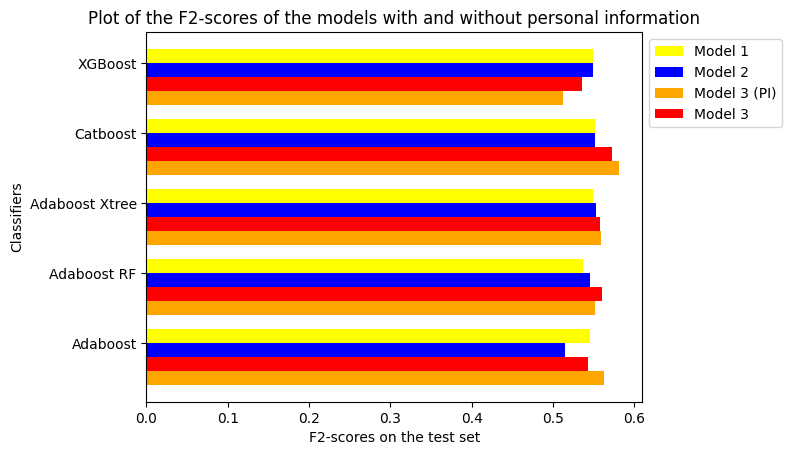

In [ ]:
test_f2_scores = [test_f2_score_ada, test_f2_score_rf, test_f2_score_X, test_f2_score_cat, test_f2_score_Xgb]
test_f2_scores_personal = [test_f2_score_ada_personal, test_f2_score_rf_personal, test_f2_score_X_personal, test_f2_score_cat_personal, test_f2_score_Xgb_personal]
test_f2_scores_personal_without = [test_f2_score_ada_personal_without, test_f2_score_rf_personal_without, test_f2_score_X_personal_without, test_f2_score_cat_personal_without, test_f2_score_Xgb_personal_without]
test_f2_scores_without = [test_f2_score_ada_without, test_f2_score_rf_without, test_f2_score_X_without, test_f2_score_cat_without, test_f2_score_Xgb_without]

labels = ["Adaboost", "Adaboost RF", "Adaboost Xtree", "Catboost", "XGBoost"]
bar_width = 0.2

fig, ax = plt.subplots()
bar1 = ax.barh(np.arange(len(labels)) + 1.5* bar_width, test_f2_scores_without, bar_width, label='Model 1', color='yellow')
bar2 = ax.barh(np.arange(len(labels)) + 0.5 * bar_width, test_f2_scores, bar_width, label='Model 2', color='blue')
bar3 = ax.barh(np.arange(len(labels)) - 1.5* bar_width, test_f2_scores_personal, bar_width, label='Model 3 (PI)', color='orange')
bar4 = ax.barh(np.arange(len(labels)) - 0.5* bar_width, test_f2_scores_personal_without, bar_width, label='Model 3', color='red')

ax.set_xlabel('F2-scores on the test set')
ax.set_ylabel('Classifiers')
ax.set_title('Plot of the F2-scores of the models with and without personal information')
ax.set_yticks(np.arange(len(labels)) + bar_width)
ax.set_yticklabels(labels)
ax.legend(bbox_to_anchor=(1, 1))

plt.show()

## Step 12: Confusion Matrix with and without personal information

In [ ]:
X_test_personal["Without_pi_X"] = y_test_pred_X
X_test_personal["Without_pi_deleted_cat"] = y_test_pred_cat_without
X_test_personal["With_pi_cat"] = y_test_pred_cat_personal
X_test_personal["With_pi_99_cat"] = y_test_pred_cat_personal_without
X_test_personal["True_Churn"] = y_test

In [ ]:
X_test_personal["True_Churn"].value_counts()

0    777
1    278
Name: True_Churn, dtype: int64

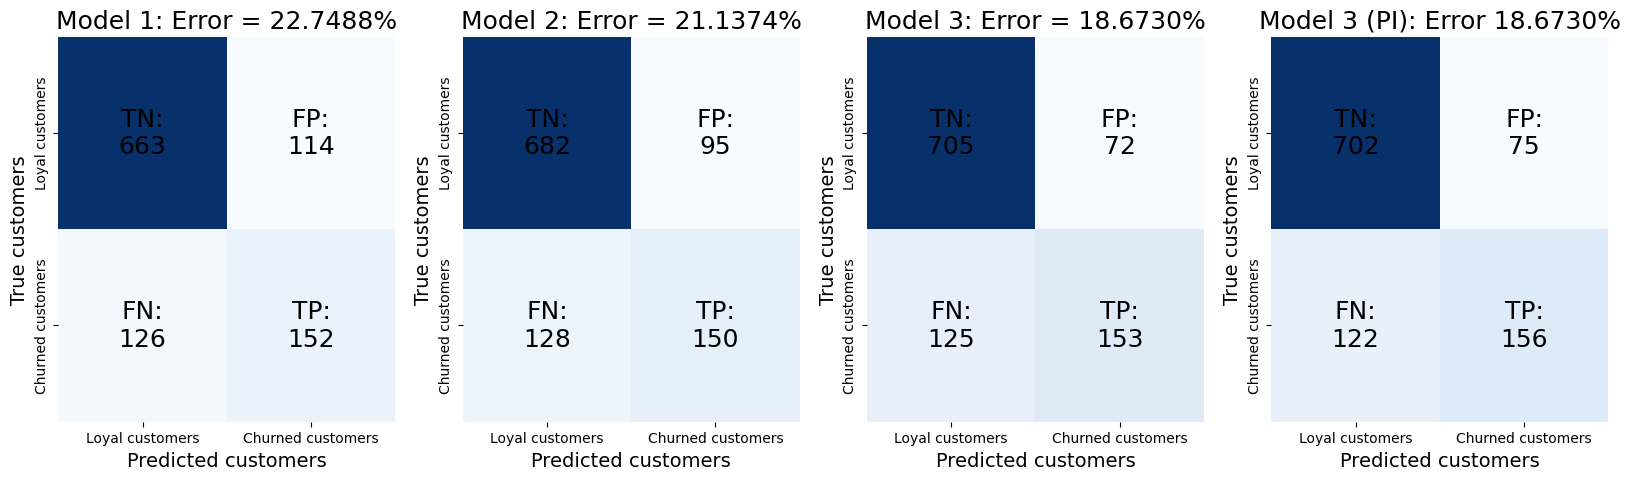

In [ ]:
cm1 = confusion_matrix(X_test_personal['True_Churn'], X_test_personal['Without_pi_deleted_cat'])
cm2 = confusion_matrix(X_test_personal['True_Churn'], X_test_personal['Without_pi_X'])
cm3_1 = confusion_matrix(X_test_personal['True_Churn'], X_test_personal['With_pi_99_cat'])
cm3_2 = confusion_matrix(X_test_personal['True_Churn'], X_test_personal['With_pi_cat'])

confusion_matrices = [cm1, cm2, cm3_1, cm3_2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

titles = ["Model 1: Error = 22.7488%", "Model 2: Error = 21.1374%", "Model 3: Error = 18.6730%", "Model 3 (PI): Error 18.6730%"]
x_title = 'Predicted customers'
y_title = 'True customers'

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar = False, xticklabels = ['Loyal customers', 'Churned customers'], yticklabels=['Loyal customers', 'Churned customers'], ax=axs[i])
    axs[i].set_title(title, fontsize = 18)
    axs[i].set_xlabel(x_title, fontsize = 14)
    axs[i].set_ylabel(y_title, fontsize = 14)

    for j in range(2):
        for k in range(2):
            annotation = ""
            if j == 1 and k == 0:
                annotation = f"FN:\n{cm[j][k]}"
            elif j == 0 and k == 1:
                annotation = f"FP:\n{cm[j][k]}"
            elif j == 1 and k == 1:
                annotation = f"TP:\n{cm[j][k]}"
            elif j == 0 and k == 0:
                annotation = f"TN:\n{cm[j][k]}"

            axs[i].text(k + 0.5, j + 0.5, annotation, ha='center', va='center', fontsize=18, color='black')
plt.show()

## Step 13: Disparate impact: Confusion matrices for females and males

In [ ]:
X_test_personal["gender"].value_counts()

0    532
1    523
Name: gender, dtype: int64

In [ ]:
X_test_personal_females = X_test_personal.loc[X_test_personal['gender'] == 0]
X_test_personal_males = X_test_personal.loc[X_test_personal['gender'] == 1]

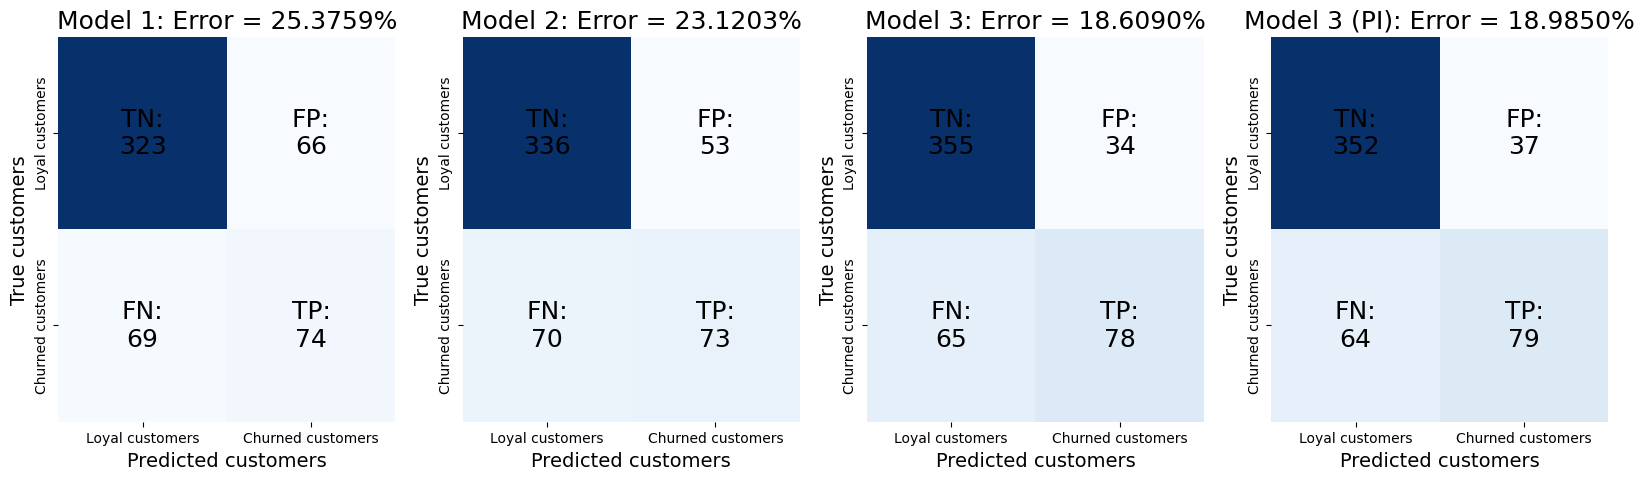

In [ ]:
cm1 = confusion_matrix(X_test_personal_females['True_Churn'], X_test_personal_females['Without_pi_deleted_cat'])
cm2 = confusion_matrix(X_test_personal_females['True_Churn'], X_test_personal_females['Without_pi_X'])
cm3_1 = confusion_matrix(X_test_personal_females['True_Churn'], X_test_personal_females['With_pi_99_cat'])
cm3_2 = confusion_matrix(X_test_personal_females['True_Churn'], X_test_personal_females['With_pi_cat'])

confusion_matrices = [cm1, cm2, cm3_1, cm3_2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

titles = ["Model 1: Error = 25.3759%", "Model 2: Error = 23.1203%", "Model 3: Error = 18.6090%", "Model 3 (PI): Error = 18.9850%"]
x_title = 'Predicted customers'
y_title = 'True customers'

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar = False, xticklabels = ['Loyal customers', 'Churned customers'], yticklabels=['Loyal customers', 'Churned customers'], ax=axs[i])
    axs[i].set_title(title, fontsize = 18)
    axs[i].set_xlabel(x_title, fontsize = 14)
    axs[i].set_ylabel(y_title, fontsize = 14)

    for j in range(2):
        for k in range(2):
            annotation = ""
            if j == 1 and k == 0:
                annotation = f"FN:\n{cm[j][k]}"
            elif j == 0 and k == 1:
                annotation = f"FP:\n{cm[j][k]}"
            elif j == 1 and k == 1:
                annotation = f"TP:\n{cm[j][k]}"
            elif j == 0 and k == 0:
                annotation = f"TN:\n{cm[j][k]}"

            axs[i].text(k + 0.5, j + 0.5, annotation, ha='center', va='center', fontsize=18, color='black')
plt.show()

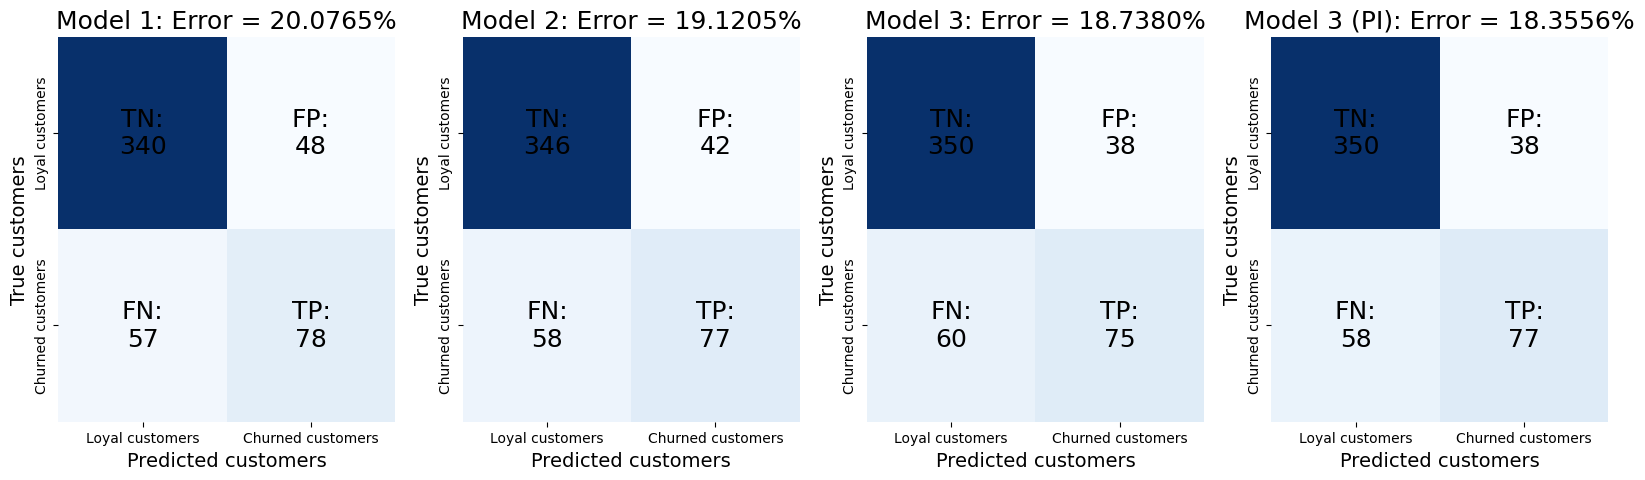

In [ ]:
cm1 = confusion_matrix(X_test_personal_males['True_Churn'], X_test_personal_males['Without_pi_deleted_cat'])
cm2 = confusion_matrix(X_test_personal_males['True_Churn'], X_test_personal_males['Without_pi_X'])
cm3_1 = confusion_matrix(X_test_personal_males['True_Churn'], X_test_personal_males['With_pi_99_cat'])
cm3_2 = confusion_matrix(X_test_personal_males['True_Churn'], X_test_personal_males['With_pi_cat'])

confusion_matrices = [cm1, cm2, cm3_1, cm3_2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

titles = ["Model 1: Error = 20.0765%", "Model 2: Error = 19.1205%", "Model 3: Error = 18.7380%", "Model 3 (PI): Error = 18.3556%"]
x_title = 'Predicted customers'
y_title = 'True customers'

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar = False, xticklabels = ['Loyal customers', 'Churned customers'], yticklabels=['Loyal customers', 'Churned customers'], ax=axs[i])
    axs[i].set_title(title, fontsize = 18)
    axs[i].set_xlabel(x_title, fontsize = 14)
    axs[i].set_ylabel(y_title, fontsize = 14)

    for j in range(2):
        for k in range(2):
            annotation = ""
            if j == 1 and k == 0:
                annotation = f"FN:\n{cm[j][k]}"
            elif j == 0 and k == 1:
                annotation = f"FP:\n{cm[j][k]}"
            elif j == 1 and k == 1:
                annotation = f"TP:\n{cm[j][k]}"
            elif j == 0 and k == 0:
                annotation = f"TN:\n{cm[j][k]}"

            axs[i].text(k + 0.5, j + 0.5, annotation, ha='center', va='center', fontsize=18, color='black')
plt.show()

## Step 14: Error analysis

In [ ]:
X_test_personal_NA = X_test_personal.loc[X_test_personal['OnlineBackup'] == 2]
X_test_personal_noNA = X_test_personal.loc[(X_test_personal['OnlineBackup'] == 0) | (X_test_personal['OnlineBackup'] == 1)]

In [ ]:
print(X_test_personal_NA.shape)
print(X_test_personal_noNA.shape)

(251, 23)
(804, 23)


In [ ]:
X_test_personal_NA['True_Churn'].value_counts()

0    238
1     13
Name: True_Churn, dtype: int64

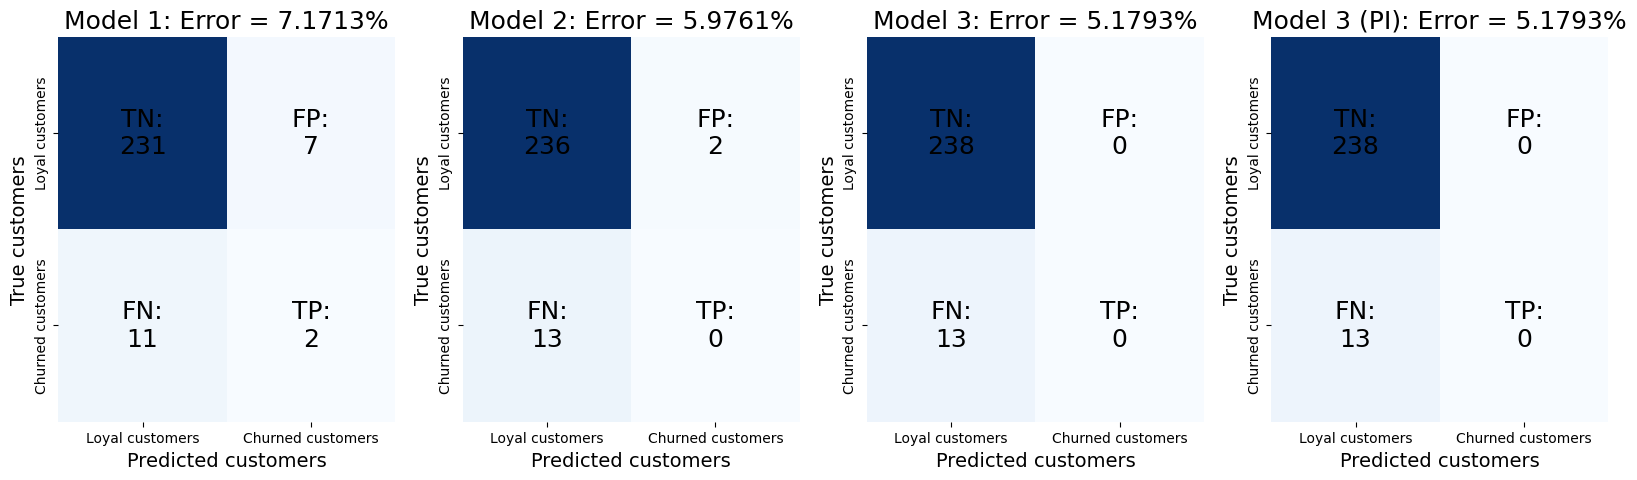

In [ ]:
cm1 = confusion_matrix(X_test_personal_NA['True_Churn'], X_test_personal_NA['Without_pi_deleted_cat'])
cm2 = confusion_matrix(X_test_personal_NA['True_Churn'], X_test_personal_NA['Without_pi_X'])
cm3_1 = confusion_matrix(X_test_personal_NA['True_Churn'], X_test_personal_NA['With_pi_99_cat'])
cm3_2 = confusion_matrix(X_test_personal_NA['True_Churn'], X_test_personal_NA['With_pi_cat'])

confusion_matrices = [cm1, cm2, cm3_1, cm3_2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

titles = ["Model 1: Error = 7.1713%", "Model 2: Error = 5.9761%", "Model 3: Error = 5.1793%", "Model 3 (PI): Error = 5.1793%"]
x_title = 'Predicted customers'
y_title = 'True customers'

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar = False, xticklabels = ['Loyal customers', 'Churned customers'], yticklabels=['Loyal customers', 'Churned customers'], ax=axs[i])
    axs[i].set_title(title, fontsize = 18)
    axs[i].set_xlabel(x_title, fontsize = 14)
    axs[i].set_ylabel(y_title, fontsize = 14)

    for j in range(2):
        for k in range(2):
            annotation = ""
            if j == 1 and k == 0:
                annotation = f"FN:\n{cm[j][k]}"
            elif j == 0 and k == 1:
                annotation = f"FP:\n{cm[j][k]}"
            elif j == 1 and k == 1:
                annotation = f"TP:\n{cm[j][k]}"
            elif j == 0 and k == 0:
                annotation = f"TN:\n{cm[j][k]}"

            axs[i].text(k + 0.5, j + 0.5, annotation, ha='center', va='center', fontsize=18, color='black')
plt.show()

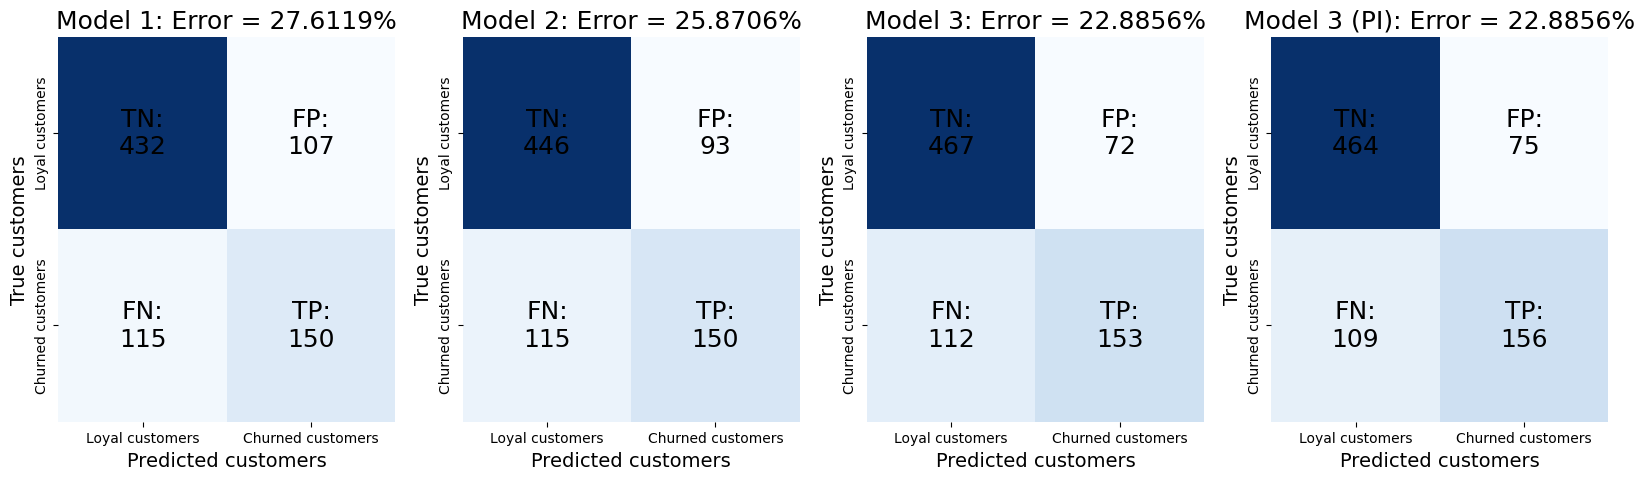

In [ ]:
cm1 = confusion_matrix(X_test_personal_noNA['True_Churn'], X_test_personal_noNA['Without_pi_deleted_cat'])
cm2 = confusion_matrix(X_test_personal_noNA['True_Churn'], X_test_personal_noNA['Without_pi_X'])
cm3_1 = confusion_matrix(X_test_personal_noNA['True_Churn'], X_test_personal_noNA['With_pi_99_cat'])
cm3_2 = confusion_matrix(X_test_personal_noNA['True_Churn'], X_test_personal_noNA['With_pi_cat'])

confusion_matrices = [cm1, cm2, cm3_1, cm3_2]

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

titles = ["Model 1: Error = 27.6119%", "Model 2: Error = 25.8706%", "Model 3: Error = 22.8856%", "Model 3 (PI): Error = 22.8856%"]
x_title = 'Predicted customers'
y_title = 'True customers'

for i, (cm, title) in enumerate(zip(confusion_matrices, titles)):
    sns.heatmap(cm, annot=False, fmt="", cmap="Blues", cbar = False, xticklabels = ['Loyal customers', 'Churned customers'], yticklabels=['Loyal customers', 'Churned customers'], ax=axs[i])
    axs[i].set_title(title, fontsize = 18)
    axs[i].set_xlabel(x_title, fontsize = 14)
    axs[i].set_ylabel(y_title, fontsize = 14)

    for j in range(2):
        for k in range(2):
            annotation = ""
            if j == 1 and k == 0:
                annotation = f"FN:\n{cm[j][k]}"
            elif j == 0 and k == 1:
                annotation = f"FP:\n{cm[j][k]}"
            elif j == 1 and k == 1:
                annotation = f"TP:\n{cm[j][k]}"
            elif j == 0 and k == 0:
                annotation = f"TN:\n{cm[j][k]}"

            axs[i].text(k + 0.5, j + 0.5, annotation, ha='center', va='center', fontsize=18, color='black')
plt.show()